In [1]:
%pylab inline
from scipy.special import spherical_jn
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erf
from classy import Class

Populating the interactive namespace from numpy and matplotlib


## PARAMETERS

In [2]:
# ell ranges
l_arr = np.arange(2,100,1)

# power spectra
non_linear = True # whether to use halofit for scalar power spectra

# cosmology
h = 0.7
A_s = 1.95e-9
n_s = 0.96
Omega_b = 0.049
omega_cdm = (0.3-0.049)*0.7**2.

# Tensor parameters
k0 = 0.05 # pivot scale in 1/Mpc
rT_fid = 1. # fiducial amplitude
chirality_fid = 1. # chirality parameter
n_t = -rT_fid/8. # power law index

# Sky fraction
f_sky = 0.36

# n(z) parameters
n_type = 'VRO' # 'euclid' or 'VRO'
if n_type=='VRO':
    alpha = 2.
    beta = 1.
    z0 = 0.3
elif n_type=='euclid':
    alpha = 2.
    z0 = 0.64
    beta = 3./2
else:
    raise Exception("Incorrect n-type")

# W(z) parameters
w_type = 'equal-chi' # 'equal-chi' or 'equal-source' or 'gaussian'
if w_type=='equal-chi':
    n_tomo = 6
    z_min = 0.
    z_max = 6.
elif w_type=='equal-source':
    n_tomo = 6
elif w_type=='gaussian':
    z_cen = 2.
    z_width = 0.03
    n_tomo = 1
else:
    raise Exception("Incorrect w-type")
    
# Noise parameters
## from 2107.09000, as relevant to Euclid
sigma_gamma = 0.4 # from 2005.04604, dimensionless
nbar_gal_arcmin = 40.
nbar_gal = nbar_gal_arcmin*(60.*180./np.pi)**2.

### Load Power Spectra

In [3]:
### CLASS VERSION
cc = Class()
cc.set({'h':h,'Omega_b':Omega_b,'A_s':A_s,'n_s':n_s,'T_cmb':2.73,
        'output':'mPk, mTk, lCl, tCl, pCl',
        'lensing':'Yes','l_max_scalars':10000,
        'l_switch_limber':9,
        'non linear':'halofit','P_k_max_1/Mpc':1000,
        'omega_cdm':omega_cdm,'z_max_pk':10})
cc.compute()
if non_linear: pk_input = np.vectorize(lambda k: cc.pk_lin(k,0))
else: pk_input = np.vectorize(lambda k: cc.pk(k,0))
Om = cc.Omega0_m()
H0 = cc.Hubble(0)
c = 1.

## Set-Up

In [4]:
# Redshift
z_arr = np.geomspace(1e-6,10,3001)

# Wavenumber (in 1/Mpc units)
k_arr = np.logspace(-6,1.,3000)
k0_arr = k_arr[:,np.newaxis]

# Conformal time today
eta0 = cc.get_current_derived_parameters(['conformal_age'])['conformal_age']

# Growth Factor
Dz_arr = np.asarray([cc.scale_independent_growth_factor(zz) for zz in z_arr])

# Comoving distance
chi_arr = np.asarray([np.sqrt(cc.luminosity_distance(zz)*cc.angular_distance(zz)) for zz in z_arr])

# Recombination distance
z_dec = cc.get_current_derived_parameters(['z_d'])['z_d']
chi_dec = np.sqrt(cc.luminosity_distance(z_dec)*cc.angular_distance(z_dec))

# Power Spectra in 1/Mpc units
Pk_delta_z0 = InterpolatedUnivariateSpline(k_arr,pk_input(k_arr),ext='zeros')

# Scalar Spectra
Pk_Phi_z0 = lambda k: Pk_delta_z0(k)/k**4.*(3./2.*H0**2.*Om)**2.

# Scale factor
a_arr = 1./(1.+z_arr)

# Matter transfer function
T_all = cc.get_transfer(0.,'class')
kTk = T_all['k (h/Mpc)']
Tk = T_all['d_cdm']

# Compute interpolator for curvature power spectrum and transfer function
Tk_interp = InterpolatedUnivariateSpline(kTk*h,Tk,ext='zeros')

#### Redshift Distribution

In [5]:
dz_dchi = InterpolatedUnivariateSpline(0.5*(z_arr[:-1]+z_arr[1:]),np.diff(z_arr)/np.diff(chi_arr))(z_arr)
n_z = (z_arr/z0)**alpha*np.exp(-(z_arr/z0)**beta)

# Normalize such that integrated n_z measures number of galaxies per steradian
n_z_norm = simps(n_z,z_arr)
n_z /= n_z_norm

# Convert to n_chi
n_chi = n_z*dz_dchi

# Split this into z bins
if w_type=='equal-chi':
    weighting = 1.
elif w_type=='equal-source':
    weighting = n_chi
elif w_type=='gaussian':
    weighting = np.exp(-(z_arr-z0)**2./(2.*z_width**2.*(1.+z_arr)**2.))
dchi = np.gradient(chi_arr)
partial_sum = np.cumsum(weighting*dchi)/np.sum(weighting*dchi)

z_cuts = [np.where(partial_sum>float(i)/n_tomo)[0][0] if i < n_tomo else -1 for i in range(n_tomo+1)]
ii = np.arange(len(n_chi))
chi_cuts = chi_arr[z_cuts].astype(int)
if w_type=='equal-source':
    n_chis_split = [n_chi*(chi_arr<chi_cuts[i+1])*(chi_arr>chi_cuts[i]) for i in range(n_tomo)]
    n_chis = [n_chis_split[i]/simps(n_chis_split[i],chi_arr) for i in range(n_tomo)]
    W_chis_split = n_chis_split/n_chi
    W_chis = [W_chis_split[i]/simps(W_chis_split[i],chi_arr) for i in range(n_tomo)]
else:
    W_chis_split = [weighting*(chi_arr<chi_cuts[i+1])*(chi_arr>chi_cuts[i]) for i in range(n_tomo)]
    W_chis = [W_chis_split[i]/simps(W_chis_split[i],chi_arr) for i in range(n_tomo)]
    n_chis_split = W_chis_split*n_chi
    n_chis = [n_chis_split[i]/simps(n_chis_split[i],chi_arr) for i in range(n_tomo)]
#n_chi_tot = n_chi*n_tomo

# Compute source density per bin
n_av = [simps(W_chis_split[i]*n_chi,chi_arr)**2/simps(n_chi*W_chis_split[i]**2,chi_arr)*nbar_gal for i in range(n_tomo)]
del n_chi

chi_dec = 1.36e+04


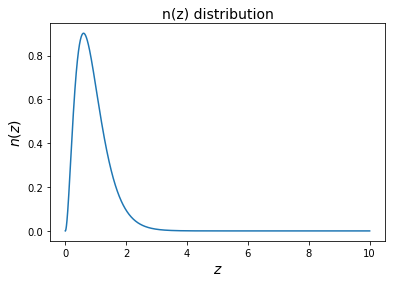

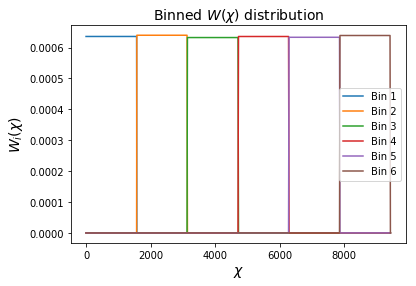

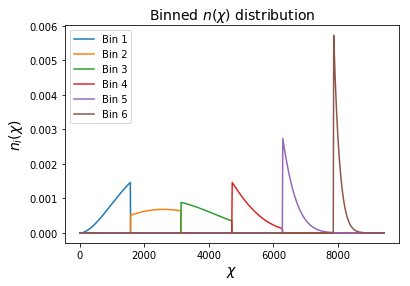

In [6]:
plt.title('n(z) distribution',fontsize=14)
plt.plot(z_arr,n_z)
plt.xlabel(r'$z$',fontsize=14)
plt.ylabel(r'$n(z)$',fontsize=14)

print("chi_dec = %.2e"%chi_dec)
plt.figure()
plt.title(r'Binned $W(\chi)$ distribution',fontsize=14)
for i in range(n_tomo):
    plt.plot(chi_arr,W_chis[i],label='Bin %d'%(i+1))
plt.xlabel(r'$\chi$',fontsize=14)
plt.ylabel(r'$W_i(\chi)$',fontsize=14)
plt.legend()

plt.figure()
plt.title(r'Binned $n(\chi)$ distribution',fontsize=14)
for i in range(n_tomo):
    plt.plot(chi_arr,n_chis[i],label='Bin %d'%(i+1))
plt.xlabel(r'$\chi$',fontsize=14)
plt.ylabel(r'$n_i(\chi)$',fontsize=14)
plt.legend()

#### Compute $q(\chi)$ and $m(\chi)$
$m_a(\chi) = \int_\chi^{\infty} d\chi_S\,W_a(\chi_S)$ which parametrizes which redshifts can lens a given bin of sources, and $q_a(\chi) = \int_{\chi}^\infty d\chi_S\,\left[\frac{\chi-\chi_S}{\chi_S}\right]n_a(\chi_S)$, for some source-weighted binning function $n_a(\chi)$.

In [7]:
chiS_arr = chi_arr[None,:]
chiL_arr = chi_arr[:,None]
q_chis = [simps(n_chis[i][None,:]*(chiS_arr-chiL_arr)/chiS_arr*(chiS_arr>chiL_arr),chiS_arr,axis=1) for i in range(n_tomo)]
m_chis = [simps(n_chis[i][None,:]*(chiS_arr>chiL_arr),chiS_arr,axis=1) for i in range(n_tomo)]
# m2 chi is same but with extra factor of chiL_arr/chiS_arr
m2_chis = [simps(n_chis[i][None,:]*(chiS_arr>chiL_arr)*chiL_arr/chiS_arr,chiS_arr,axis=1) for i in range(n_tomo)]

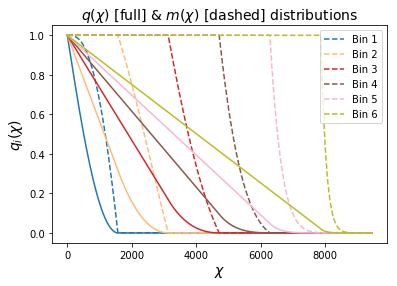

In [8]:
plt.figure()
plt.title(r'$q(\chi)$ [full] & $m(\chi)$ [dashed] distributions',fontsize=14)
cs = cm.tab20
for i in range(n_tomo):
    plt.plot(chi_arr,m_chis[i],label='Bin %d'%(i+1),ls='--',c=cs(i*1./n_tomo))
    plt.plot(chi_arr,q_chis[i],c=cs(i*1./n_tomo))
plt.xlabel(r'$\chi$',fontsize=14)
plt.ylabel(r'$q_i(\chi)$',fontsize=14)
plt.legend()

## Set-Up

In [9]:
### Useful shear + pSZ quantities

# IA bias
C1S_rhocr0 = 0.1
bias_IA_chi = (2./3.)*C1S_rhocr0/H0**2.*(1.+0.*chi_arr)

print("Assuming intrinsic alignment bias of %.3f (in 2/(3 Omega_m H_0^2) units)"%(3.*Om*H0**2./2.*bias_IA_chi.mean()))

# Equality scale
z_eq = cc.Omega_m()/(1.-cc.Omega_Lambda()-cc.Omega_m())-1 # including neutrinos!
a_eq = 1./(1.+z_eq)

# chi array up to recombination
z_all = np.geomspace(1e-6,2000,1003)
chi_all = np.asarray([np.sqrt(cc.luminosity_distance(zz)*cc.angular_distance(zz)) for zz in z_all])
a_all = 1./(1.+z_all)

Dz_all = np.asarray([cc.scale_independent_growth_factor(zz) for zz in z_all])

# # Potential time dependence
def D_psi_a(a):
    y = a/a_eq
    a_all2 = np.linspace(0.00001,a,10000)
    fac1 = (16.*np.sqrt(1.+y)+9.*y**3.+2.*y**2.-8.*y-16.)/(10.*y**3.)
    fac2 = (5./2.*Om*np.sqrt(Om/a**3.+1.-Om)/a)
    fac3 = simps((a_all2<a)/np.sqrt(Om/a_all2**3.+1.-Om)**3./a_all2**3.,a_all2)
    return fac1*fac2*fac3
D_psi_all = np.asarray([D_psi_a(a) for a in a_all])

## Approximate form!
# D_psi_all = 0.7*Dz_all/a_all
# D_psi_a = InterpolatedUnivariateSpline(a_all[::-1],D_psi_all[::-1],ext=0)

D_psi = InterpolatedUnivariateSpline((eta0-chi_all)[::-1],D_psi_all[::-1],ext=0)
deriv_D_psi = lambda eta: (D_psi(eta*1.001)-D_psi(eta*0.999))/(0.002*eta)

H_a = lambda a: cc.Hubble(1./a-1.)

# Velocity time dependence
def D_v_a(a):
    y = a/a_eq
    part1 = 2.*a**2.*H_a(a)/(H0**2.*cc.Omega0_m())*y/(4.+3.*y)
    part2 = D_psi_a(a)+(D_psi_a(a*1.001)-D_psi_a(a*0.999))/0.002
    out = part1*part2
    return out

filt = z_all>1e-3
D_v = InterpolatedUnivariateSpline((eta0-chi_all[filt])[::-1],np.asarray([D_v_a(a) for a in a_all[filt]])[::-1],ext=0)

Assuming intrinsic alignment bias of 0.030 (in 2/(3 Omega_m H_0^2) units)


Text(0,0.5,'$D_X(z)/D_X(0)$')

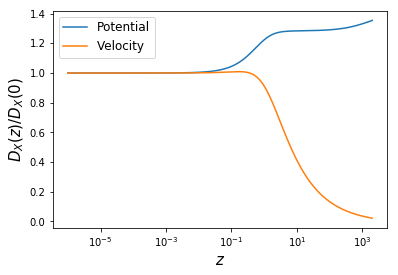

In [13]:
plt.plot(z_all,D_psi(eta0-chi_all)/D_psi(eta0),label='Potential')
plt.plot(z_all,D_v(eta0-chi_all)/D_v(eta0),label='Velocity')
plt.xscale('log')
plt.legend(fontsize=12)
plt.xlabel(r'$z$',fontsize=15)
plt.ylabel(r'$D_X(z)/D_X(0)$',fontsize=15)

In [14]:
# Define quadrupole transfer functions
def G_SW(chiE):
    return -(2.*D_psi(eta0-chi_dec)-3./2.)*spherical_jn(2,k_arr*(chi_dec-chiE))
def G_ISW(chiE):
    chiT_arr = np.linspace(chiE+0.00001,chi_dec,101)
    return -2.*simps(deriv_D_psi(eta0-chiT_arr)*spherical_jn(2,k0_arr*(chiT_arr-chiE)),chiT_arr)
def G_Doppler(chiE):
    return (1./5.)*k_arr*D_v(eta0-chi_dec)*(3.*spherical_jn(3,k_arr*(chi_dec-chiE))-2.*spherical_jn(1,k_arr*(chi_dec-chiE)))

**Plot $\mathcal{G}$ kernels**

Compare with 1705.08907, Fig. 2.

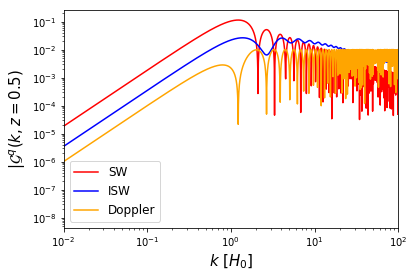

In [15]:
G_SW_arr = []
G_ISW_arr = []
G_Doppler_arr = []
for i,chiE in enumerate(chi_arr):
    G_SW_arr.append(G_SW(chiE))
    G_ISW_arr.append(G_ISW(chiE))
    G_Doppler_arr.append(G_Doppler(chiE))
G_SW_arr = np.asarray(G_SW_arr).T
G_ISW_arr = np.asarray(G_ISW_arr).T
G_Doppler_arr = np.asarray(G_Doppler_arr).T

z_i = np.argmin(np.abs(z_arr-0.5))
plt.plot(k_arr/H0,np.abs(G_SW_arr[:,z_i]),ls='-',c='r',label='SW')
plt.plot(k_arr/H0,np.abs(G_ISW_arr[:,z_i]),ls='-',c='b',label='ISW')
plt.plot(k_arr/H0,np.abs(G_Doppler_arr[:,z_i]),ls='-',c='orange',label='Doppler')
plt.legend(fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,100])
plt.ylabel(r'$|\mathcal{G}^q(k,z=%.1f)$'%z_arr[z_i],fontsize=15)
plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);

## Scalar Kernels

**Shear Kernels**
\begin{eqnarray}
    \Delta_\ell^{\gamma^E,\rm S}(k,\chi) = i^{\ell}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\left[-\frac{b_S(\chi)}{2\chi^2}T_S(\eta_0-\chi)j_\ell(k\chi)+\frac{1}{c^2}\int_0^\chi\frac{d\chi'}{\chi'}\left(\frac{\chi'-\chi}{\chi}\right)T_S(\eta_0-\chi')j_\ell(k\chi')\right].
\end{eqnarray}

with $b_{\rm S}(\chi)\equiv(2/3)C^{\rm S}_{1}\rho_{cr0}H_0^{-2}$ for $\rho_{cr0}=3H_0^2/(8\pi G)$, and $C_1^{\rm S}\rho_{cr0}\sim 0.1$.

On redshift integration:
\begin{eqnarray}
    \Delta_{\ell,a}^{\gamma^E,\rm S}(k) = i^{\ell}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\left[-\int d\chi\,n_a(\chi)\frac{b_S(\chi)}{2\chi^2}T_S(\eta_0-\chi)j_\ell(k\chi)+\frac{1}{c^2}\int_0^\chi\frac{d\chi'}{\chi'}q_a(\chi')T_S(\eta_0-\chi')j_\ell(k\chi')\right].
\end{eqnarray}

**pSZ Kernels**
\begin{eqnarray}
    \Delta_\ell^{q^E,\rm S}(k,\chi) = -5i^\ell \sqrt{\frac{3}{8}}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\frac{j_\ell(k\chi)}{(k\chi)^2}\left[\mathcal{G}_{\rm SW}+\mathcal{G}_{\rm ISW}+\mathcal{G}_{\rm Doppler}\right](k,\chi).
\end{eqnarray}
for kernels
\begin{eqnarray}
    \mathcal{G}_{\rm SW}(k,\chi) &=& -\left(2D_\Psi(\eta_d)-\frac{3}{2}\right)j_2(k[\chi_d-\chi])\\\nonumber
    \mathcal{G}_{\rm ISW}(k,\chi) &=& -2\int_{\chi}^{\chi_d} d\bar\chi\,\partial_\eta D_\Psi(\bar\eta)j_2(k[\bar\chi-\chi])\\\nonumber
    \mathcal{G}_{\rm Doppler}(k,\chi) &=& \frac{1}{5}kD_v(\eta_d)\left(3j_3(k[\chi_d-\chi])-2j_1(k[\chi_d-\chi])\right)
\end{eqnarray}
where $D_\Psi$ is the $\Psi$ growth rate and $D_v$ is the velocity potential growth rate. On redshift integration:
\begin{eqnarray}
    \Delta_{\ell,a}^{q^E,\rm S}(k) = -5i^{\ell}\sqrt{\frac{3}{8}}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\int d\chi\,n_a(\chi)\frac{j_\ell(k\chi)}{(k\chi)^2}\left[\mathcal{G}_{\rm SW}+\mathcal{G}_{\rm ISW}+\mathcal{G}_{\rm Doppler}\right](k,\chi).
\end{eqnarray}

**Galaxy Kernels**
\begin{eqnarray}
    \Delta_\ell^{g,\rm S}(k,\chi) = -i^\ell\frac{2a(\chi)k^2}{3H_0^2\Omega_m}b_g(\chi)D_{\rm S}(\chi)j_\ell(k\chi),
\end{eqnarray}
for galaxy bias $b_g$.

In [16]:
### Compute all required Bessel functions
all_l = np.arange(0,max(l_arr)+2)
all_jl = [spherical_jn(l,k0_arr*chi_arr) for l in all_l]

# Compute galaxy bias
bz_arr = 0.95/Dz_arr

In [17]:
def compute_scalar_kernels(l):
    """Compute the Delta_ell(k, chi) kernels, integrated over redshift bins, for scalar sources."""
    
    assert l>=2
    
    # Bessel functions
    x = k0_arr*chi_arr
    jl = all_jl[l]
    jl1 = all_jl[l+1]
    
    # Bessel function derivatives
    djl = l/x*jl-jl1
    d2jl = (l*(l-1)-x**2.)/x**2.*jl+2./x*jl1
    d3jl = (l-2)*(l*(l-1)-x**2.)/x**3.*jl+(x**2.-l*(l-1.)-6.)/x**2.*jl1
    d4jl = ((l-3)*(l-2)*(l-1)*l-2.*(l*(l-1)+4)*x**2.+x**4.)/x**4.*jl + 4.*(6.+2*l*(l+1.)-x**2.)/x**3.*jl1
    
    # Initialize kernels
    kernel_gE_scalar_IA = []
    kernel_gE_scalar_lens = []
    kernel_gE_scalar_tot = []
    
    kernel_qE_scalar_SW = []
    kernel_qE_scalar_ISW = []
    kernel_qE_scalar_Doppler = []
    kernel_qE_scalar_tot = []
    
    kernel_gal_scalar = []
    
    # Iterate over redshift bins
    for i in range(n_tomo):
        
        pref_gE = ((1.0j)**l)*np.sqrt((l+2.)*(l+1.)*l*(l-1.))
        pref_qE = -5.*(1.0j)**l*np.sqrt(3./8.)*np.sqrt((l+2.)*(l+1.)*l*(l-1.))
        pref_g = (1.0j)**l
        
        # Shear
        kernel_gE_scalar_IA.append(-pref_gE*simps(n_chis[i]*bias_IA_chi/(2.*chi_arr**2.)*Dz_arr*jl,chi_arr))
        kernel_gE_scalar_lens.append(pref_gE/c**2.*simps(q_chis[i]/chi_arr*Dz_arr*jl,chi_arr))
        kernel_gE_scalar_tot.append(kernel_gE_scalar_IA[-1]+kernel_gE_scalar_lens[-1])

        # pSZ 
        kernel_qE_scalar_SW.append(pref_qE*simps(n_chis[i]*jl/x**2.*G_SW_arr,chi_arr))
        kernel_qE_scalar_ISW.append(pref_qE*simps(n_chis[i]*jl/x**2.*G_ISW_arr,chi_arr))
        kernel_qE_scalar_Doppler.append(pref_qE*simps(n_chis[i]*jl/x**2.*G_Doppler_arr,chi_arr))
        kernel_qE_scalar_tot.append(kernel_qE_scalar_SW[-1]+kernel_qE_scalar_ISW[-1]+kernel_qE_scalar_Doppler[-1])
        
        # Galaxies
        kernel_gal_scalar.append(pref_g*-2./(3.*H0**2.*Om)*simps(n_chis[i]*a_arr*bz_arr*Dz_arr*jl*k0_arr**2.,chi_arr))
    return kernel_gE_scalar_IA, kernel_gE_scalar_lens, kernel_gE_scalar_tot, kernel_qE_scalar_SW, kernel_qE_scalar_ISW, kernel_qE_scalar_Doppler, kernel_qE_scalar_tot, kernel_gal_scalar

all_kernels = np.asarray([compute_scalar_kernels(l) for l in l_arr])

shear_kernels_scalar, psz_kernels_scalar, gal_kernels_scalar = all_kernels[:,:3], all_kernels[:,3:7], all_kernels[:,7]

/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


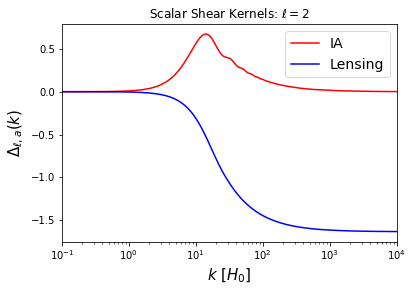

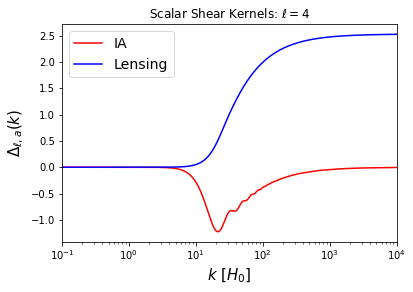

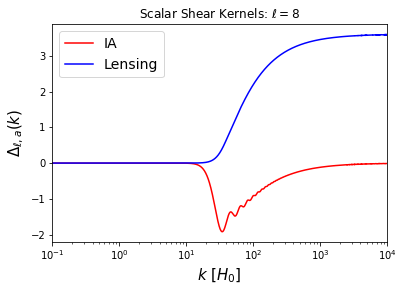

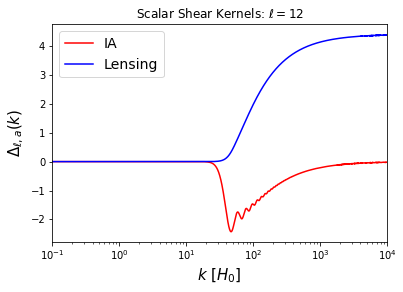

In [18]:
bin_index = 0
for i in [0,2,6,10]:
    plt.figure()
    plt.title('Scalar Shear Kernels: $\ell = %d$'%l_arr[i])
    plt.plot(k_arr/H0,shear_kernels_scalar[i][0][bin_index],label=r'IA',c='r')
    plt.plot(k_arr/H0,shear_kernels_scalar[i][1][bin_index],label=r'Lensing',c='b')
    plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);
    plt.legend(fontsize=14)
    plt.ylabel(r'$\Delta_{\ell,a}(k)$',fontsize=15);
    plt.xscale('log')
    plt.xlim([1e-1,1e4])

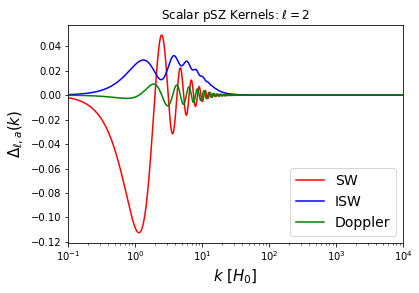

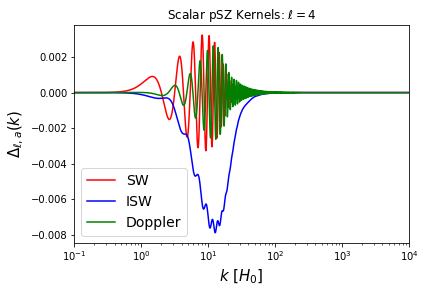

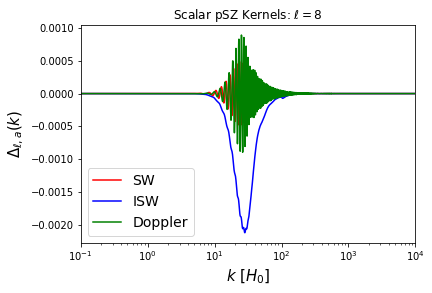

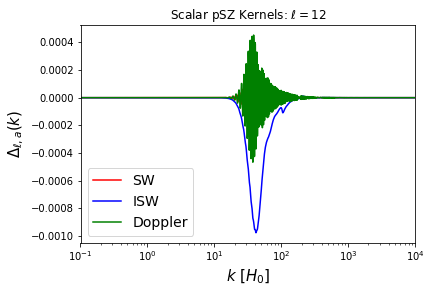

In [19]:
for i in [0,2,6,10]:
    plt.figure()
    plt.title('Scalar pSZ Kernels: $\ell = %d$'%l_arr[i])
    plt.plot(k_arr/H0,psz_kernels_scalar[i][0][bin_index],label=r'SW',c='r')
    plt.plot(k_arr/H0,psz_kernels_scalar[i][1][bin_index],label=r'ISW',c='b')
    plt.plot(k_arr/H0,psz_kernels_scalar[i][2][bin_index],label=r'Doppler',c='g')
    plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);
    plt.legend(fontsize=14)
    plt.ylabel(r'$\Delta_{\ell,a}(k)$',fontsize=15);
    plt.xscale('log')
    plt.xlim([1e-1,1e4])

## Scalar Spectra

Spectra:
$$C_{\ell,ab}^{XY} = 4\pi\int_{0}^\infty d\log k\,\Delta^X_{\ell,a}(k)\Delta^{Y*}_{\ell,b}(k)\mathcal{P}_\Phi(k)$$
in bins $a,b$.

In [20]:
# Power spectra
calP_phi_arr = (k_arr**3.)/(2.*np.pi**2.)*Pk_Phi_z0(k_arr)

def compute_scalar_spectra(kernel1, kernel2):
    """Compute the full (non-Limber) scalar spectra given two kernels, using the dimensionless power spectrum of Phi."""
    
    Cl_out = np.zeros((n_tomo,n_tomo,len(l_arr)))

    for l_i in range(len(l_arr)):
        for i in range(n_tomo):
            for j in range(n_tomo):
                Cl_out[i,j,l_i] = 4.*np.pi*simps(1./k_arr*kernel1[l_i,i]*np.conj(kernel2[l_i,j])*calP_phi_arr,k_arr).real

    return Cl_out    

In [21]:
# Shear scalar spectra
Cl_gEgE_scalar_IA = compute_scalar_spectra(shear_kernels_scalar[:,0],shear_kernels_scalar[:,0])
Cl_gEgE_scalar_lens = compute_scalar_spectra(shear_kernels_scalar[:,1],shear_kernels_scalar[:,1])
Cl_gEgE_scalar_tot = compute_scalar_spectra(shear_kernels_scalar[:,2],shear_kernels_scalar[:,2])

# pSZ scalar spectra
Cl_qEqE_scalar_SW = compute_scalar_spectra(psz_kernels_scalar[:,0],psz_kernels_scalar[:,0])
Cl_qEqE_scalar_ISW = compute_scalar_spectra(psz_kernels_scalar[:,1],psz_kernels_scalar[:,1])
Cl_qEqE_scalar_Doppler = compute_scalar_spectra(psz_kernels_scalar[:,2],psz_kernels_scalar[:,2])
Cl_qEqE_scalar_tot = compute_scalar_spectra(psz_kernels_scalar[:,3],psz_kernels_scalar[:,3])

# Galaxy spectra
Cl_gg_scalar = compute_scalar_spectra(gal_kernels_scalar,gal_kernels_scalar)

# pSZ / shear cross-spectra
Cl_qEgE_scalar_SW = compute_scalar_spectra(psz_kernels_scalar[:,0],shear_kernels_scalar[:,2])
Cl_qEgE_scalar_ISW = compute_scalar_spectra(psz_kernels_scalar[:,1],shear_kernels_scalar[:,2])
Cl_qEgE_scalar_Doppler = compute_scalar_spectra(psz_kernels_scalar[:,2],shear_kernels_scalar[:,2])
Cl_qEgE_scalar_tot = compute_scalar_spectra(psz_kernels_scalar[:,3],shear_kernels_scalar[:,2])
Cl_qEgE_scalar_IA = compute_scalar_spectra(psz_kernels_scalar[:,3],shear_kernels_scalar[:,0])
Cl_qEgE_scalar_lens = compute_scalar_spectra(psz_kernels_scalar[:,3],shear_kernels_scalar[:,1])
Cl_gEqE_scalar_tot = compute_scalar_spectra(shear_kernels_scalar[:,2],psz_kernels_scalar[:,3])
Cl_qEgE_scalar_SW_lens = compute_scalar_spectra(psz_kernels_scalar[:,0],shear_kernels_scalar[:,1])
Cl_qEgE_scalar_ISW_lens = compute_scalar_spectra(psz_kernels_scalar[:,1],shear_kernels_scalar[:,1])
Cl_qEgE_scalar_Doppler_lens = compute_scalar_spectra(psz_kernels_scalar[:,2],shear_kernels_scalar[:,1])

# pSZ / galaxies cross-spectra
Cl_qEg_scalar_SW = compute_scalar_spectra(psz_kernels_scalar[:,0],gal_kernels_scalar)
Cl_qEg_scalar_ISW = compute_scalar_spectra(psz_kernels_scalar[:,1],gal_kernels_scalar)
Cl_qEg_scalar_Doppler = compute_scalar_spectra(psz_kernels_scalar[:,2],gal_kernels_scalar)
Cl_qEg_scalar_tot = compute_scalar_spectra(psz_kernels_scalar[:,3],gal_kernels_scalar)

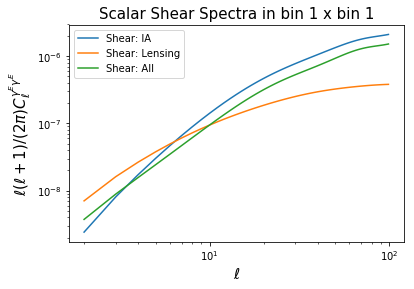

In [22]:
bin1 = 0
bin2 = 0
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Scalar Shear Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gEgE_scalar_IA[bin1,bin2],label='Shear: IA')
plt.plot(l_arr,pref*Cl_gEgE_scalar_lens[bin1,bin2],label='Shear: Lensing')
plt.plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Shear: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend();

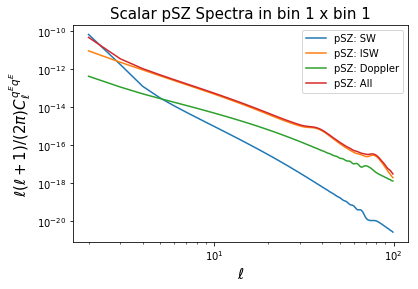

In [23]:
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Scalar pSZ Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_qEqE_scalar_SW[bin1,bin2],label='pSZ: SW')
plt.plot(l_arr,pref*Cl_qEqE_scalar_ISW[bin1,bin2],label='pSZ: ISW')
plt.plot(l_arr,pref*Cl_qEqE_scalar_Doppler[bin1,bin2],label='pSZ: Doppler')
plt.plot(l_arr,pref*Cl_qEqE_scalar_tot[bin1,bin2],label='pSZ: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{q^Eq^E}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend();

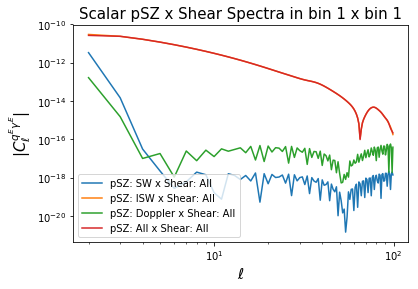

In [24]:
bin1 = 0
bin2 = 0
plt.title('Scalar pSZ x Shear Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,np.abs(Cl_qEgE_scalar_SW[bin1,bin2]),label='pSZ: SW x Shear: All')
plt.plot(l_arr,np.abs(Cl_qEgE_scalar_ISW[bin1,bin2]),label='pSZ: ISW x Shear: All')
plt.plot(l_arr,np.abs(Cl_qEgE_scalar_Doppler[bin1,bin2]),label='pSZ: Doppler x Shear: All')
plt.plot(l_arr,np.abs(Cl_qEgE_scalar_tot[bin1,bin2]),label='pSZ: All x Shear: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$|C_\ell^{q^E\gamma^E}|$',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.legend();

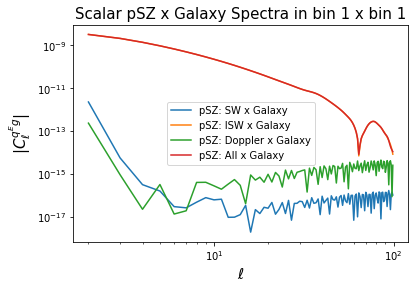

In [25]:
bin1 = 0
bin2 = 0
plt.title('Scalar pSZ x Galaxy Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,np.abs(Cl_qEg_scalar_SW[bin1,bin2]),label='pSZ: SW x Galaxy')
plt.plot(l_arr,np.abs(Cl_qEg_scalar_ISW[bin1,bin2]),label='pSZ: ISW x Galaxy')
plt.plot(l_arr,np.abs(Cl_qEg_scalar_Doppler[bin1,bin2]),label='pSZ: Doppler x Galaxy')
plt.plot(l_arr,np.abs(Cl_qEg_scalar_tot[bin1,bin2]),label='pSZ: All x Galaxy')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$|C_\ell^{q^Eg}|$',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.legend();

## Tensor Spectra

**Shear Kernels**
\begin{eqnarray}
     -i^{-\ell}\Delta_\ell^{\gamma^X,\rm{T}}(k,\chi) &=& -\,\frac{1}{8}\left.\mathcal{O}_X\left[\hat Q_{\rm IA,T}(x)\right]\frac{j_\ell(x)}{x^{2}}\right|_{x=0}D_{\rm T}(k,\eta_0)\\\nonumber 
    &&\,-\,\frac{1}{8}\mathcal{O}_X\left[\hat Q_{\rm IA,T}(x)\right]\frac{j_\ell(x)}{x^{2}}\left(1-b_{\rm T}(\chi)a^{-2}(\partial_\eta^2+aH\partial_\eta)\right)D_{\rm T}(k,\eta_0-\chi)\\\nonumber 
    &&\,+\,\frac{1}{4}\int_{0}^{\chi}\frac{d\chi'}{\chi'}\left(\mathcal{O}_X\left[\hat Q_{\rm lens,T,1}(x')\right]+\frac{\chi'}{\chi}\mathcal{O}_X\left[\hat Q_{\rm lens,T,2}(x')\right]\right)\frac{j_\ell(x')}{x'^2}D_{\rm T}(k,\eta_0-\chi'),
\end{eqnarray}

with $b_{\rm T}(\chi)\equiv(2/3)C^{\rm T}_{1}\rho_{cr0}H_0^{-2}$ for $\rho_{cr0}=3H_0^2/(8\pi G)$, and $C_1^{\rm T}\rho_{cr0}\sim 0.1$. The $\hat Q$ operators are defined by

\begin{eqnarray}
\hat Q_{\rm lens,T,1}(x) &=& -\frac{x}{2}\left[x(x^2+14)+2(7x^2+20)\partial_x+2x(x^2+25)\partial_x^2+14x^2\partial_x^3+x^3\partial_x^4\right.\\\nonumber
    &&\,\left.-2i\left(4 + x^2 + 6 x\partial_x + x^2\partial_x^2\right)\right]\\\nonumber
    \hat Q_{\rm lens,T,2}(x) &=& \frac{1}{2}\left[24(x^2+1)+x^4+16x(x^2+6)\partial_x+2x^2(x^2+36)\partial_x^2+16x^3\partial_x^3+x^4\partial_x^4\right],\\\nonumber
    \hat{Q}_{\rm IA,T}(x) &=& \left[12-x^2+8x\partial_x + x^2\partial_x^2\right] + 2ix\left[4+x\partial_x\right],
\end{eqnarray}

On redshift integration:
\begin{eqnarray}
     -i^{-\ell}\Delta_\ell^{\gamma^X,\rm{T}}(k,\chi) &=& -\,\frac{1}{8}\left.\mathcal{O}_X\left[\hat Q_{\rm IA,T}(x)\right]\frac{j_\ell(x)}{x^{2}}\right|_{x=0}D_{\rm T}(k,\eta_0)\\\nonumber 
    &&\,-\,\frac{1}{8}\int_0^\infty d\chi\,n_a(\chi)\mathcal{O}_X\left[\hat Q_{\rm IA,T}(x)\right]\frac{j_\ell(x)}{x^{2}}\left(1-b_{\rm T}(\chi)a^{-2}(\chi)(\partial_\eta^2+aH\partial_\eta)\right)D_{\rm T}(k,\eta_0-\chi)\\\nonumber 
    &&\,+\,\frac{1}{4}\int_{0}^{\infty}\frac{d\chi'}{\chi'}\left(m_a(\chi')\mathcal{O}_X\left[\hat Q_{\rm lens,T,1}(x')\right]+\bar{m}_a(\chi')\mathcal{O}_X\left[\hat Q_{\rm lens,T,2}(x')\right]\right)\frac{j_\ell(x')}{x'^2}D_{\rm T}(k,\eta_0-\chi'),
\end{eqnarray}

for $$m_a(\chi') = \int_{\chi'}^\infty d\chi\,n_a(\chi), \qquad \bar m_a(\chi') = \int_{\chi'}^\infty d\chi\,\frac{\chi'}{\chi}n_a(\chi)$$

**pSZ Kernels**

\begin{eqnarray}
    i^{-\ell}\Delta_\ell^{q^E,\rm T}(k,\chi) &=& \frac{5\sqrt{6}}{4}\mathrm{Re}\left[\hat Q_{\rm IA,T}(x)\right]\frac{j_\ell(x)}{x^2}\int_\chi^{\chi_d}d\bar\chi\,\partial_\eta D_T(\bar\eta)\frac{j_2(k[\bar\eta-\eta])}{(k[\bar\eta-\eta])^2}\\\nonumber
    i^{-\ell}\Delta_\ell^{q^B,\rm T}(k,\chi) &=& -\frac{5\sqrt{6}}{4}\mathrm{Im}\left[\hat Q_{\rm IA,T}(x)\right]\frac{j_\ell(x)}{x^2}\int_\chi^{\chi_d}d\bar\chi\,\partial_\eta D_T(\bar\eta)\frac{j_2(k[\bar\eta-\eta])}{(k[\bar\eta-\eta])^2},
\end{eqnarray}

#### Set-Up

In [26]:
### Set up power spectra and transfer functions

H_arr = np.asarray([cc.Hubble(zz) for zz in z_arr])

# Primordial scalar amplitude at this wavenumber
Delta2_sca_k0 = A_s*(k0/0.05)**(cc.n_s()-1.)

# Primordial power spectrum
calP_tensor_arr = (rT_fid*Delta2_sca_k0*(k_arr/k0)**n_t)

def T_tensor(k):
    """Tensor mode transfer function"""
    eta = eta0-chi_arr
    return 3.*spherical_jn(1,k*eta)/(k*eta)

def T_tensor_IA(k):
    """Tensor mode transfer function including the intrinsic alignment operator [d_eta^2+(aH)d_eta]"""
    eta = eta0-chi_arr
    return (3.*(k*eta*np.cos(k*eta)*(-12.+k**2*eta**2.+3.*eta*a_arr*H_arr)+(12.-5.*k**2.*eta**2.+eta*(-3.+k**2.*eta**2.)*a_arr*H_arr)*np.sin(k*eta)))/(k**3*eta**5.)

T_tensor_arr = T_tensor(k0_arr)
T_tensor_IA_arr = T_tensor_IA(k0_arr)

In [27]:
# Define pSZ integrand for each chi_e
def pSZ_integ(chiE):
    eta = eta0-chiE
    DT_part = 3.*(np.sin(eta*k0_arr)-3.*spherical_jn(1,k0_arr*eta))/(eta**2.*k0_arr)
    chiT_arr = np.linspace(chiE+0.00001,chi_dec,101)
    integ = simps(spherical_jn(2,k0_arr*(chiT_arr-chiE))/(k0_arr*(chiT_arr-chiE))**2.*DT_part,chiT_arr)
    return integ

pSZ_integ_arr = np.asarray([pSZ_integ(chiE) for chiE in chi_arr]).T

Text(0.5,0,'$k\\,[H_0]$')

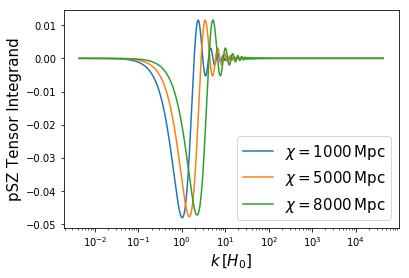

In [28]:
plt.plot(k_arr/H0,pSZ_integ(1000.),label=r'$\chi = 1000\,\mathrm{Mpc}$')
plt.plot(k_arr/H0,pSZ_integ(5000.),label=r'$\chi = 5000\,\mathrm{Mpc}$')
plt.plot(k_arr/H0,pSZ_integ(8000.),label=r'$\chi = 8000\,\mathrm{Mpc}$')
plt.legend(fontsize=15)
plt.ylabel('pSZ Tensor Integrand',fontsize=15)
plt.xscale('log')
plt.xlabel(r'$k\,[H_0]$',fontsize=15)

In [29]:
def compute_tensor_kernels(l):
    """Compute the Delta_ell(k, chi) kernels, integrated over redshift bins, for tensor sources."""
    
    assert l>=2
    
    # Compute Bessel functions and derivatives
    x = k0_arr*chi_arr
    jl = all_jl[l]
    jl1 = all_jl[l+1]
    jlm1 = all_jl[l-1]
    
    # Compute derivatives of j_l(x)/x^2
    jlx = jl/x**2.
    djlx = (x*jlm1-5.*jl-x*jl1)/(2.*x**3.)
    d2jlx = (-2.*x*jlm1+(8.-l+l**2.-x**2.)*jl+4.*x*jl1)/x**4.
    d3jlx = (9.*x*jlm1 + (-33.+8.*l-9.*l**2.+l**3.+8.*x**2.-l*x**2.)*jl+x*(-27.-l-l**2.+x**2.)*jl1)/x**5.
    d4jlx = (-48.*x*jlm1+(168.-14.*l**3.+l**4.-60.*x**2.+x**4.+l**2.*(71.-2.*x**2.)+2.*l*(-29.+5*x**2.))*jl+4.*x*(48.+4.*l+4.*l**2.-3.*x**2.)*jl1)/x**6.
    
    # Q_{lens, 1, T}[j_l(x)/x^2]
    Re_Qjx_lens1 = -x/2.*(x*(x**2.+14.)*jlx+2.*(7.*x**2.+20.)*djlx+2.*x*(x**2.+25.)*d2jlx+14.*x**2.*d3jlx+x**3.*d4jlx)
    Im_Qjx_lens1 = x*((4.+x**2.)*jlx+6.*x*djlx+x**2*d2jlx)
    
    # Q_{lens, 2, T}[j_l(x)/x^2]
    Re_Qjx_lens2 =  0.5*(24.*(x**2.+1.)*jlx+x**4.*jlx+16.*x*(x**2.+6.)*djlx+2.*x**2.*(x**2.+36.)*d2jlx+16.*x**3.*d3jlx+x**4.*d4jlx)
    Im_Qjx_lens2 = 0.
    
    # Q_{IA, T}[j_l(x)/x^2]
    Re_Qjx_IA = (12.-x**2.)*jlx+8.*x*djlx+x**2.*d2jlx
    Im_Qjx_IA = 2.*x*(4.*jlx+x*djlx)
    
    # Initialize kernels
    kernel_gE_IA = []
    kernel_gE_lens = []
    kernel_gE_tot = []
    kernel_gB_IA = []
    kernel_gB_lens = []
    kernel_gB_tot = []    
    kernel_qE = []
    kernel_qB = []
    
    # Iterate over redshift bins
    for i in range(n_tomo):
        
        pref_g = ((1.0j)**(-l))/8.
        pref_q = 5.*np.sqrt(6.)/4.*(1.0j)**l
        
        ## Shear: IA
        kernel_gE_IA.append(-pref_g*simps(n_chis[i]*bias_IA_chi/a_arr**2.*T_tensor_IA_arr*Re_Qjx_IA,chi_arr))
        kernel_gB_IA.append(-pref_g*simps(n_chis[i]*bias_IA_chi/a_arr**2.*T_tensor_IA_arr*Im_Qjx_IA,chi_arr))
        
        ## Shear: Lensing
        # Observer term
        if l==2:
            p1E = 4./5.*(3.*spherical_jn(1,k0_arr*eta0)/(k0_arr*eta0)).ravel()
            p1B = 0.
        else:
            p1E = 0.
            p1B = 0.
        # Source term
        p2E = simps(n_chis[i]*T_tensor_arr*Re_Qjx_IA,chi_arr)
        p2B = simps(n_chis[i]*T_tensor_arr*Im_Qjx_IA,chi_arr)
        # Lensing term
        p3E = -2.*simps(T_tensor_arr/chi_arr*(m_chis[i]*Re_Qjx_lens1+m2_chis[i]*Re_Qjx_lens2),chi_arr)
        p3B = -2.*simps(T_tensor_arr/chi_arr*(m_chis[i]*Im_Qjx_lens1+m2_chis[i]*Im_Qjx_lens2),chi_arr)
        
        # Output
        kernel_gE_lens.append(pref_g*(p1E+p2E+p3E))
        kernel_gB_lens.append(pref_g*(p1B+p2B+p3B))
        
        ## Shear: Combined
        kernel_gE_tot.append(kernel_gE_IA[-1]+kernel_gE_lens[-1])
        kernel_gB_tot.append(kernel_gB_IA[-1]+kernel_gB_lens[-1])
        
        ## pSZ
        kernel_qE.append(pref_q*simps(n_chis[i]*pSZ_integ_arr*Re_Qjx_IA,chi_arr))
        kernel_qB.append(-pref_q*simps(n_chis[i]*pSZ_integ_arr*Im_Qjx_IA,chi_arr))
        
    return kernel_gE_IA, kernel_gE_lens, kernel_gE_tot, kernel_gB_IA, kernel_gB_lens, kernel_gB_tot, kernel_qE, kernel_qB

all_kernels = np.asarray([compute_tensor_kernels(l) for l in l_arr])
shear_kernels_tensor, psz_kernels_tensor = all_kernels[:,:6], all_kernels[:,6:]

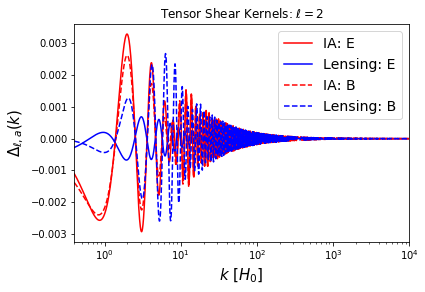

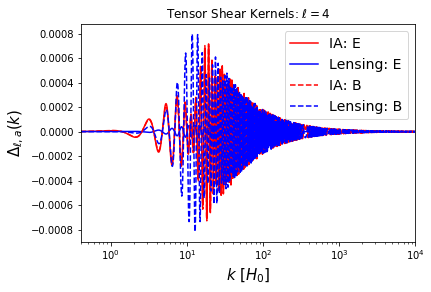

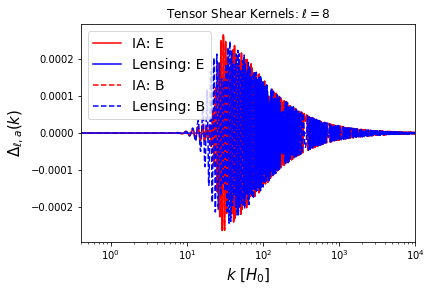

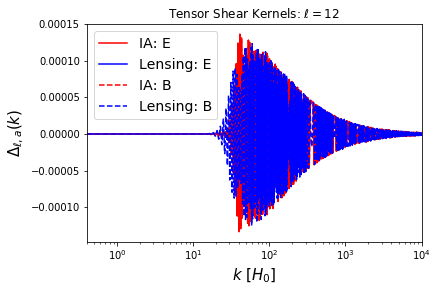

In [30]:
for i in [0,2,6,10]:
    plt.figure()
    plt.title('Tensor Shear Kernels: $\ell = %d$'%l_arr[i])
    plt.plot(k_arr/H0,shear_kernels_tensor[i][0][0],label=r'IA: E',c='r')
    plt.plot(k_arr/H0,shear_kernels_tensor[i][1][0],label=r'Lensing: E',c='b')
    plt.plot(k_arr/H0,shear_kernels_tensor[i][2][0],label=r'IA: B',c='r',ls='--')
    plt.plot(k_arr/H0,shear_kernels_tensor[i][3][0],label=r'Lensing: B',c='b',ls='--')
    plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);
    plt.legend(fontsize=14)
    plt.ylabel(r'$\Delta_{\ell,a}(k)$',fontsize=15);
    plt.xscale('log')
    plt.xlim([4e-1,1e4])

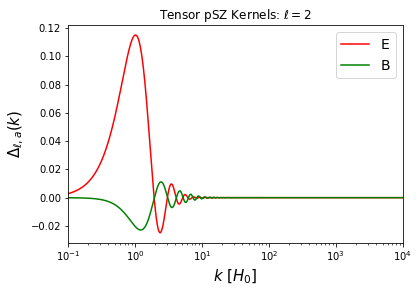

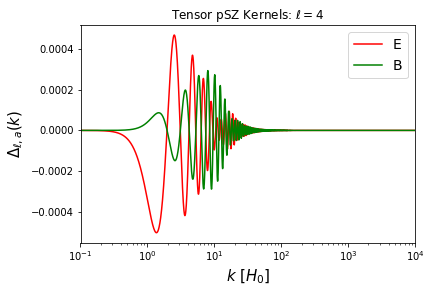

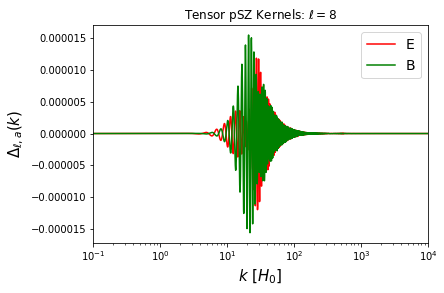

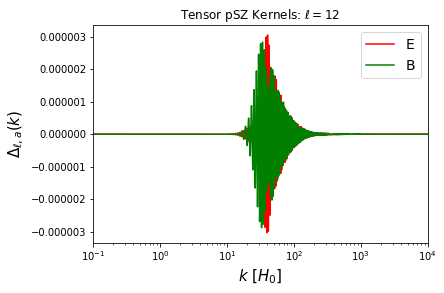

In [31]:
for i in [0,2,6,10]:
    plt.figure()
    plt.title('Tensor pSZ Kernels: $\ell = %d$'%l_arr[i])
    plt.plot(k_arr/H0,psz_kernels_tensor[i][0][0],label=r'E',c='r')
    plt.plot(k_arr/H0,psz_kernels_tensor[i][1][0],label=r'B',c='g')
    plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);
    plt.legend(fontsize=14)
    plt.ylabel(r'$\Delta_{\ell,a}(k)$',fontsize=15);
    plt.xscale('log')
    plt.xlim([1e-1,1e4])

## Tensor Spectra

Spectra:
$$C_{\ell,ab}^{XY} = 4\pi\int_{0}^\infty d\log k\,\Delta^X_{\ell,a}(k)\Delta^{Y*}_{\ell,b}(k)\mathcal{P}_h(k)\times\left[\delta_{\rm K}^{XY}+(1-\delta_{\rm K}^{XY})\Delta_h\right],$$
in bins $a,b$.

In [32]:
def compute_tensor_spectra(kernel1, kernel2, chiral=False):
    """Compute the full (non-Limber) scalar spectra given two kernels, using the dimensionless power spectrum of Phi."""
    
    Cl_out = np.zeros((n_tomo,n_tomo,len(l_arr)))

    if chiral:
        h_spectra_arr = calP_tensor_arr*chirality_fid
    else:
        h_spectra_arr = calP_tensor_arr
    
    for l_i in range(len(l_arr)):
        for i in range(n_tomo):
            for j in range(n_tomo):
                Cl_out[i,j,l_i] = 4.*np.pi*simps(1./k_arr*kernel1[l_i,i]*np.conj(kernel2[l_i,j])*h_spectra_arr,k_arr).real

    return Cl_out    

In [33]:
# Shear tensor spectra
Cl_gEgE_tensor_IA = compute_tensor_spectra(shear_kernels_tensor[:,0],shear_kernels_tensor[:,0])
Cl_gEgE_tensor_lens = compute_tensor_spectra(shear_kernels_tensor[:,1],shear_kernels_tensor[:,1])
Cl_gEgE_tensor_tot = compute_tensor_spectra(shear_kernels_tensor[:,2],shear_kernels_tensor[:,2])
Cl_gBgB_tensor_IA = compute_tensor_spectra(shear_kernels_tensor[:,3],shear_kernels_tensor[:,3])
Cl_gBgB_tensor_lens = compute_tensor_spectra(shear_kernels_tensor[:,4],shear_kernels_tensor[:,4])
Cl_gBgB_tensor_tot = compute_tensor_spectra(shear_kernels_tensor[:,5],shear_kernels_tensor[:,5])
Cl_gEgB_tensor_IA = compute_tensor_spectra(shear_kernels_tensor[:,0],shear_kernels_tensor[:,3],chiral=True)
Cl_gEgB_tensor_lens = compute_tensor_spectra(shear_kernels_tensor[:,1],shear_kernels_tensor[:,4],chiral=True)
Cl_gEgB_tensor_tot = compute_tensor_spectra(shear_kernels_tensor[:,2],shear_kernels_tensor[:,5],chiral=True)

# pSZ tensor spectra
Cl_qEqE_tensor = compute_tensor_spectra(psz_kernels_tensor[:,0],psz_kernels_tensor[:,0])
Cl_qBqB_tensor = compute_tensor_spectra(psz_kernels_tensor[:,1],psz_kernels_tensor[:,1])
Cl_qEqB_tensor = compute_tensor_spectra(psz_kernels_tensor[:,0],psz_kernels_tensor[:,1],chiral=True)

# Cross spectra
Cl_qEgE_tensor_IA = compute_tensor_spectra(psz_kernels_tensor[:,0],shear_kernels_tensor[:,0])
Cl_qEgE_tensor_lens = compute_tensor_spectra(psz_kernels_tensor[:,0],shear_kernels_tensor[:,1])
Cl_qEgE_tensor_tot = compute_tensor_spectra(psz_kernels_tensor[:,0],shear_kernels_tensor[:,2])
Cl_qBgB_tensor_IA = compute_tensor_spectra(psz_kernels_tensor[:,1],shear_kernels_tensor[:,3])
Cl_qBgB_tensor_lens = compute_tensor_spectra(psz_kernels_tensor[:,1],shear_kernels_tensor[:,4])
Cl_qBgB_tensor_tot = compute_tensor_spectra(psz_kernels_tensor[:,1],shear_kernels_tensor[:,5])
Cl_qEgB_tensor_IA = compute_tensor_spectra(psz_kernels_tensor[:,0],shear_kernels_tensor[:,3],chiral=True)
Cl_qEgB_tensor_lens = compute_tensor_spectra(psz_kernels_tensor[:,0],shear_kernels_tensor[:,4],chiral=True)
Cl_qEgB_tensor_tot = compute_tensor_spectra(psz_kernels_tensor[:,0],shear_kernels_tensor[:,5],chiral=True)
Cl_qBgE_tensor_IA = compute_tensor_spectra(psz_kernels_tensor[:,1],shear_kernels_tensor[:,0],chiral=True)
Cl_qBgE_tensor_lens = compute_tensor_spectra(psz_kernels_tensor[:,1],shear_kernels_tensor[:,1],chiral=True)
Cl_qBgE_tensor_tot = compute_tensor_spectra(psz_kernels_tensor[:,1],shear_kernels_tensor[:,2],chiral=True)

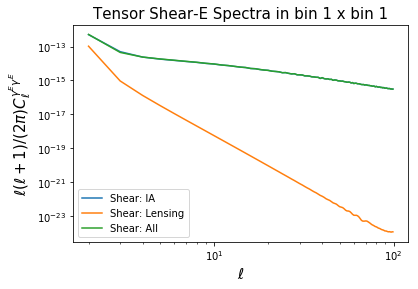

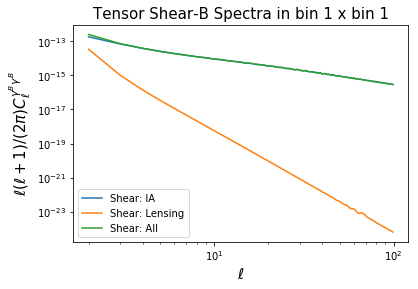

In [34]:
bin1 = 0
bin2 = 0
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.figure()
plt.title('Tensor Shear-E Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gEgE_tensor_IA[bin1,bin2],label='Shear: IA')
plt.plot(l_arr,pref*Cl_gEgE_tensor_lens[bin1,bin2],label='Shear: Lensing')
plt.plot(l_arr,pref*Cl_gEgE_tensor_tot[bin1,bin2],label='Shear: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend();
plt.figure()
plt.title('Tensor Shear-B Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gBgB_tensor_IA[bin1,bin2],label='Shear: IA')
plt.plot(l_arr,pref*Cl_gBgB_tensor_lens[bin1,bin2],label='Shear: Lensing')
plt.plot(l_arr,pref*Cl_gBgB_tensor_tot[bin1,bin2],label='Shear: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^B\gamma^B}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend();

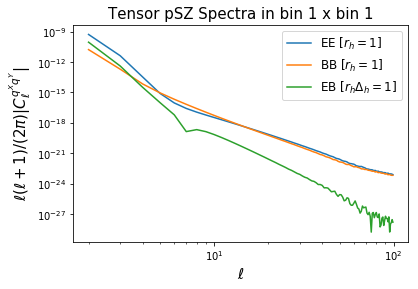

In [35]:
bin1 = 0
bin2 = 0
plt.figure()
plt.title('Tensor pSZ Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_qEqE_tensor[bin1,bin2],label='EE $[r_h=1]$')
plt.plot(l_arr,pref*Cl_qBqB_tensor[bin1,bin2],label='BB $[r_h=1]$')
plt.plot(l_arr,np.abs(Cl_qEqB_tensor[bin1,bin2]),label='EB $[r_h\Delta_h = 1]$')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)|C_\ell^{q^Xq^Y}|$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12);

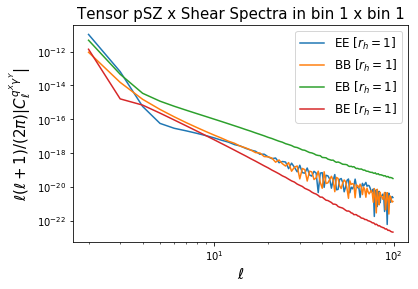

In [36]:
plt.figure()
plt.title('Tensor pSZ x Shear Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*np.abs(Cl_qEgE_tensor_tot[bin1,bin2]),label='EE $[r_h=1]$')
plt.plot(l_arr,pref*np.abs(Cl_qBgB_tensor_tot[bin1,bin2]),label='BB $[r_h=1]$')
plt.plot(l_arr,pref*np.abs(Cl_qEgB_tensor_tot[bin1,bin2]),label='EB $[r_h=1]$')
plt.plot(l_arr,np.abs(Cl_qBgE_tensor_tot[bin1,bin2]),label='BE $[r_h=1]$')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)|C_\ell^{q^X\gamma^Y}|$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12);

## Shear and Galaxy Noise Spectra

In [37]:
# if opt_errors, increase nbar by a factor 2.5 and use Delta T_CMB = 0.1 muK-arcmin
opt_errors = False

In [38]:
# Shear noise
# NB: same number density in each bin!
Cl_gg_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
Cl_gEgE_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
Cl_gBgB_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
for i in range(n_tomo):
    if opt_errors:
        this_n = n_av[i]*2.5
    else:
        this_n = n_av[i]
    Cl_gg_noise[i,i] = 1./this_n*(1.+0.*l_arr)
    Cl_gEgE_noise[i,i] = sigma_gamma**2./this_n*(1.+0.*l_arr)
    Cl_gBgB_noise[i,i] = sigma_gamma**2./this_n*(1.+0.*l_arr)

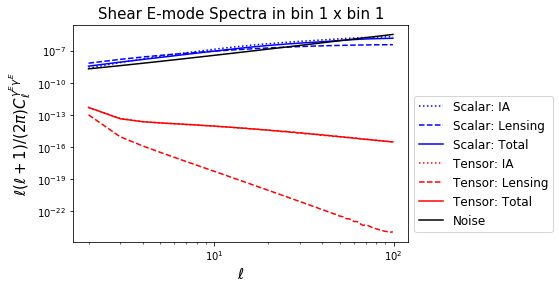

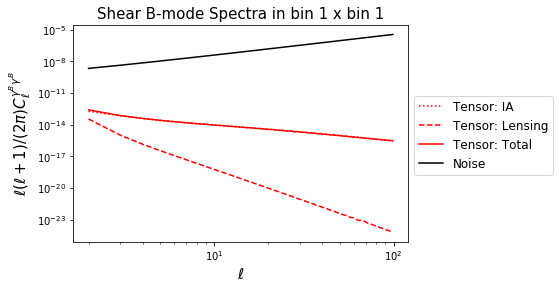

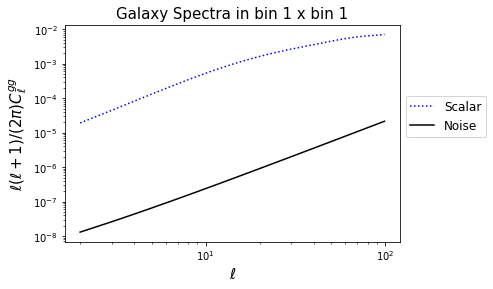

In [39]:
bin1 = 0
bin2 = 0
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Shear E-mode Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gEgE_scalar_IA[bin1,bin2],label='Scalar: IA',c='b',ls=':')
plt.plot(l_arr,pref*Cl_gEgE_scalar_lens[bin1,bin2],label='Scalar: Lensing',c='b',ls='--')
plt.plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.plot(l_arr,pref*Cl_gEgE_tensor_IA[bin1,bin2],label='Tensor: IA',c='r',ls=':')
plt.plot(l_arr,pref*Cl_gEgE_tensor_lens[bin1,bin2],label='Tensor: Lensing',c='r',ls='--')
plt.plot(l_arr,pref*Cl_gEgE_tensor_tot[bin1,bin2],label='Tensor: Total',c='r',ls='-')
plt.plot(l_arr,pref*Cl_gEgE_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('Shear B-mode Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gBgB_tensor_IA[bin1,bin2],label='Tensor: IA',c='r',ls=':')
plt.plot(l_arr,pref*Cl_gBgB_tensor_lens[bin1,bin2],label='Tensor: Lensing',c='r',ls='--')
plt.plot(l_arr,pref*Cl_gBgB_tensor_tot[bin1,bin2],label='Tensor: Total',c='r',ls='-')
plt.plot(l_arr,pref*Cl_gBgB_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^B\gamma^B}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('Galaxy Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gg_scalar[bin1,bin2],label='Scalar',c='b',ls=':')
plt.plot(l_arr,pref*Cl_gg_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{gg}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

## pSZ Noise Spectra

##### 1) CMB Spectra

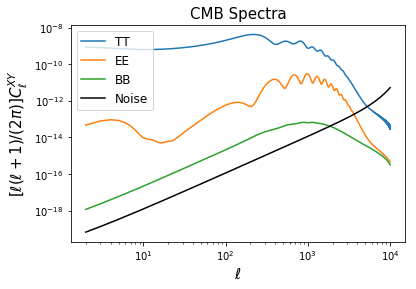

In [40]:
# l array for high-l 
highl_arr = np.geomspace(1,1e4,100)

# Lensed CMB spectra
cl = cc.lensed_cl(10000)
ll = cl['ell'][2:]
clTT = cl['tt'][2:]
clEE = cl['ee'][2:]
clBB = cl['bb'][2:]

# CMB Noise spectra
def Nl_CMB(deltaT, thetaFWHM):
    amp = 1e-6*deltaT/60.*np.pi/180./T_cmb # in radians
    fwhm = thetaFWHM/60.*np.pi/180. # in radians
    return amp**2*np.exp(ll*(ll+1.)*fwhm**2./(8.*np.log(2.)))

thetaFWHM = 1.
deltaPol = 1. # in microK-arcmin
if opt_errors:
    deltaPol = 0.1
T_cmb = cc.T_cmb()

# Plot CMB spectra
# NB: plotting in dimensionless units always
plt.plot(ll,ll*(ll+1.)*clTT,label='TT')
plt.plot(ll,ll*(ll+1.)*clEE,label='EE')
plt.plot(ll,ll*(ll+1.)*clBB,label='BB')
plt.plot(ll,ll*(ll+1.)*Nl_CMB(deltaPol,thetaFWHM),label='Noise',c='k')
plt.yscale('log')
plt.legend(fontsize=12)
plt.title("CMB Spectra",fontsize=15)
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$[\ell(\ell+1)/(2\pi)]C_\ell^{XY}$',fontsize=15);
plt.xscale('log')

ClEE = InterpolatedUnivariateSpline(ll,clEE+Nl_CMB(deltaPol,thetaFWHM))(highl_arr)
ClBB = InterpolatedUnivariateSpline(ll,clBB+Nl_CMB(deltaPol,thetaFWHM))(highl_arr)
del clEE, clBB

##### 2) Galaxy Spectra

In [41]:
# Thomson cross section
sigmaT = 6.6524587321e-29*(3.24078e-23)**2 # in Mpc^2

# Current baryon density
cchi = cc.get_background()['comov. dist.']
crho_b = cc.get_background()['(.)rho_b']
# in 1/Mpc^2
rho_b_chi = InterpolatedUnivariateSpline(cchi[::-1],crho_b[::-1])
    
# Conversion factors (from CLASS)   
GeV_over_kg = 1.78266191e-27
Mpc_over_GeV = 1.56373832e38
Mpc_over_m = 3.086e+22
GeVcm3_over_Mpc2 = 94.7024726

print("Current baryon density: %.2e g/cm^3"%(rho_b_chi(0.)*GeVcm3_over_Mpc2*GeV_over_kg*1000.))

# Constants
sigmaT = 6.6524616e-29/Mpc_over_m**2. # in Mpc^2
m_proton = 1.672621637e-27/GeV_over_kg # in GeV

# Assume electron density = hydrogen + helium * baryons, assuming mostly ionized
n_e_chi = lambda chi: (0.75+0.25/2.)*rho_b_chi(chi)/m_proton*1e6*GeVcm3_over_Mpc2*Mpc_over_m**3. # in 1/Mpc^3
print("Current electron number density: %.2e cm^-3"%(n_e_chi(0.)/1e6/Mpc_over_m**3.))

Current baryon density: 4.51e-31 g/cm^3
Current electron number density: 2.36e-07 cm^-3


In [42]:
# Power spectra
calP_m_arr = (k_arr**3.)/(2.*np.pi**2.)*Pk_delta_z0(k_arr)

# Galaxy spectra
Cl_gal_gal = np.zeros((n_tomo,n_tomo,len(highl_arr)))

# Galaxy-tau spectra
Cl_tau_gal = np.zeros((n_tomo,n_tomo,len(highl_arr)))

Dz_func = InterpolatedUnivariateSpline(chi_arr,Dz_arr,ext='zeros')
a_func = InterpolatedUnivariateSpline(chi_arr,a_arr,ext='zeros')
bz_arr = 0.95/Dz_arr
bz_func = InterpolatedUnivariateSpline(chi_arr,bz_arr,ext='zeros')
n_funcs = [InterpolatedUnivariateSpline(chi_arr,n_chis[i],ext='zeros') for i in range(n_tomo)]

for l_i,l in enumerate(highl_arr):
    
    # Compute in Limber approximation
    chis = (l+0.5)/k_arr
    for i in range(n_tomo):
        if opt_errors:
            this_n = n_av[i]*2.5
        else:
            this_n = n_av[i]
        Cl_gal_gal[i,i,l_i] = simps(n_funcs[i](chis)**2*bz_func(chis)**2.*Dz_func(chis)**2.*Pk_delta_z0(k_arr)/(l+0.5),k_arr)+1./this_n
        Cl_tau_gal[i,i,l_i] = sigmaT*simps(a_func(chis)*n_e_chi(chis)*n_funcs[i](chis)*bz_func(chis)*Dz_func(chis)**2.*Pk_delta_z0(k_arr)/(l+0.5),k_arr)

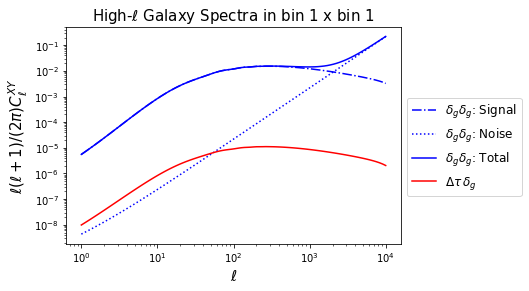

In [43]:
bin1 = 0
bin2 = 0
pref = highl_arr*(highl_arr+1.)/(2.*np.pi)
this_n = n_av[bin1]*(1.+1.5*opt_errors)
plt.title(r'High-$\ell$ Galaxy Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(highl_arr,pref*(Cl_gal_gal[bin1,bin2]-(bin1==bin2)/this_n),label=r'$\delta_g\delta_g$: Signal',c='b',ls='-.')
plt.plot(highl_arr,pref*(1./this_n)*(bin1==bin2),label=r'$\delta_g\delta_g$: Noise',c='b',ls=':')
plt.plot(highl_arr,pref*Cl_gal_gal[bin1,bin2],label=r'$\delta_g\delta_g$: Total',c='b')
plt.plot(highl_arr,pref*Cl_tau_gal[bin1,bin2],label=r'$\Delta\tau\,\delta_g$',c='r',ls='-');
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{XY}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

##### 3) Combination to noise spectrum

\begin{eqnarray}
    \Gamma_{\ell\ell_1\ell_2}^{\rm pSZ}(\chi) = -\frac{\sqrt{6}}{10}\sqrt{\frac{(2\ell+1)(2\ell_1+1)(2\ell_2+1)}{4\pi}}\begin{pmatrix}\ell &\ell_1&\ell_2\\2&-2&0\end{pmatrix}C_{\ell_2}^{\Delta \tau\delta_g}(\chi).
\end{eqnarray}

\begin{eqnarray}
\frac{1}{N_{\ell,ab}^{q^Eq^E}} &=& \frac{\delta_{\rm K}^{ab}}{(2\ell+1)}\sum_{\ell_1\ell_2}\frac{\Gamma_{\ell\ell_1\ell_2,a}^{\rm pSZ}\Gamma_{\ell\ell_1\ell_2,a}^{\rm pSZ}}{\left(|\alpha_{\ell\ell_1\ell_2}|^2C_{\ell_1}^{EE}+|\gamma_{\ell\ell_1\ell_2}|^2C_{\ell_1}^{BB}\right)C_{\ell_2,a}^{\delta_g\delta_g}}\\\nonumber
    \frac{1}{N_{\ell,ab}^{q^Bq^B}} &=& \frac{\delta_{\rm K}^{ab}}{(2\ell+1)}\sum_{\ell_1\ell_2}\frac{\Gamma_{\ell\ell_1\ell_2,a}^{\rm pSZ}\Gamma_{\ell\ell_1\ell_2,a}^{\rm pSZ}}{\left(|\gamma_{\ell\ell_1\ell_2}|^2C_{\ell_1}^{EE}+|\alpha_{\ell\ell_1\ell_2}|^2C_{\ell_1}^{BB}\right)C_{\ell_2,a}^{\delta_g\delta_g}},
\end{eqnarray}

We precompute all $3j$ symbols with https://github.com/xzackli/WignerFamilies.jl in Julia.

In [44]:
tj_arr = np.load('/projects/QUIJOTE/Oliver/wig3j_array.npz')

In [45]:
# Interpolators for spectra at high-l
ClEE_func = InterpolatedUnivariateSpline(highl_arr,ClEE)
ClBB_func = InterpolatedUnivariateSpline(highl_arr,ClBB)
Clgg_func = [InterpolatedUnivariateSpline(highl_arr,Cl_gal_gal[bin1,bin1]) for bin1 in range(n_tomo)]
Cltaug_func = [InterpolatedUnivariateSpline(highl_arr,Cl_tau_gal[bin1,bin1]) for bin1 in range(n_tomo)]

# Utility functions
alphaSq = lambda l,l1,l2: 1.*((l+l1+l2)%2==0)
gammaSq = lambda l,l1,l2: 1.*((l+l1+l2)%2==1)

Cl_qEqE_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
Cl_qBqB_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))

# Create arrays of Cls for speed
min_l = 1
max_l = 10000
clBs = [ClBB_func(l) for l in range(1,max_l+1)]
clEs = [ClEE_func(l) for l in range(1,max_l+1)]

def Gamma_pSZ(l,l1,l2_arr,bin1):
    pref = -np.sqrt(6.)/10.*np.sqrt((2.*l+1.)*(2.*l1+1.)*(2.*l2_arr+1.)/(4.*np.pi))
    tj = tj_arr[l-1,l1-1,:len(l2_arr)]
    spec = Cltaug_func[bin1](l2_arr)
    return pref*tj*spec

In [46]:
for bin1 in range(n_tomo):
    print(bin1)
    for l_i in range(len(l_arr)):
        l = l_arr[l_i]
        sumE = 0.
        sumB = 0.
        for l1 in range(min_l,max_l+1):
            # sum over all l2 in allowed range
            clB = clBs[l1-1]
            clE = clEs[l1-1]
            l2s = np.arange(max([l1-l,0]),min([l1+l,max_l])+1)
            GpSZ = Gamma_pSZ(l,l1,l2s,bin1)**2.
            aSq = alphaSq(l,l1,l2s)
            gSq = gammaSq(l,l1,l2s)
            clg = Clgg_func[bin1](l2s)
            sumE += np.sum(GpSZ/((aSq*clE+gSq*clB)*clg))
            sumB += np.sum(GpSZ/((gSq*clE+aSq*clB)*clg))
        Cl_qEqE_noise[bin1,bin1,l_i] = (2.*l+1.)/sumE
        Cl_qBqB_noise[bin1,bin1,l_i] = (2.*l+1.)/sumB

0
1
2
3
4
5


### All contribution plots

In [47]:
shear_signal = True
psz_signal = True

# Compute total spectra under null assumptions
Cl_gEgE = shear_signal*Cl_gEgE_scalar_tot+Cl_gEgE_noise
Cl_gEgB = 0.*Cl_gEgE
Cl_gEqE = shear_signal*psz_signal*Cl_gEqE_scalar_tot
Cl_gEqB = 0.*Cl_gEgE

Cl_gBgE = 0.*Cl_gEgE
Cl_gBgB = Cl_gBgB_noise
Cl_gBqE = 0.*Cl_gEgE
Cl_gBqB = 0.*Cl_gEqE

Cl_qEgE = shear_signal*psz_signal*Cl_qEgE_scalar_tot
Cl_qEgB = 0.*Cl_gEgE
Cl_qEqE = psz_signal*Cl_qEqE_scalar_tot+Cl_qEqE_noise
Cl_qEqB = 0.*Cl_gEgE

Cl_qBgE = 0.*Cl_gEgE
Cl_qBgB = 0.*Cl_gEgE
Cl_qBqE = 0.*Cl_gEgE
Cl_qBqB = Cl_qBqB_noise

Cl_gg = Cl_gg_scalar+Cl_gg_noise
Cl_qEg = psz_signal*Cl_qEg_scalar_tot
Cl_gqE = psz_signal*Cl_qEg_scalar_tot.swapaxes(0,1)

Bins: 5 x 5


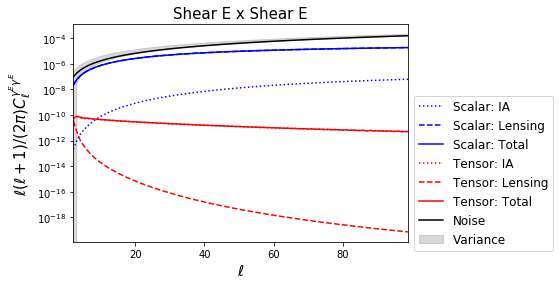

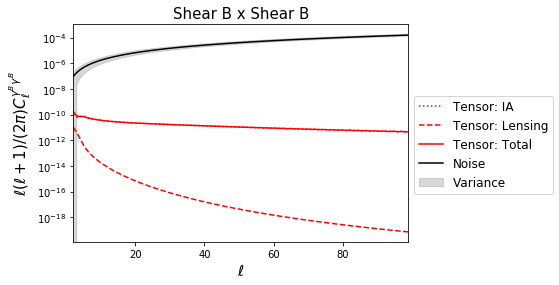

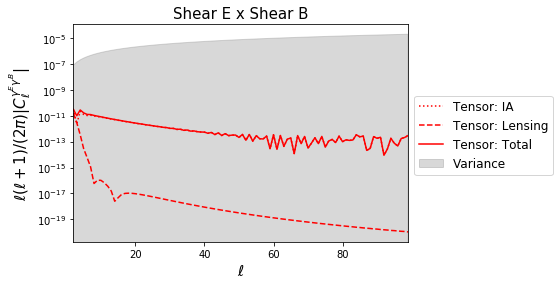

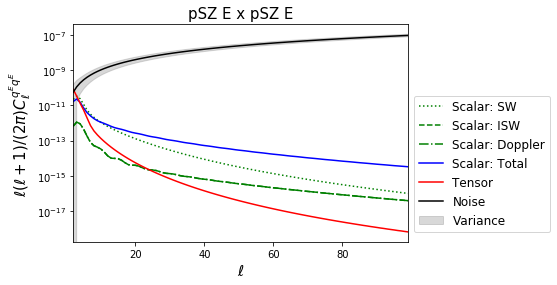

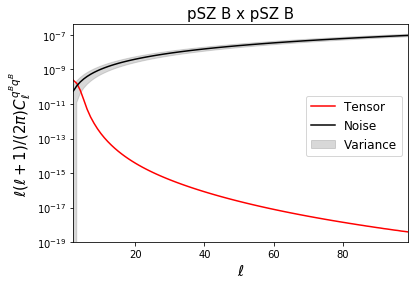

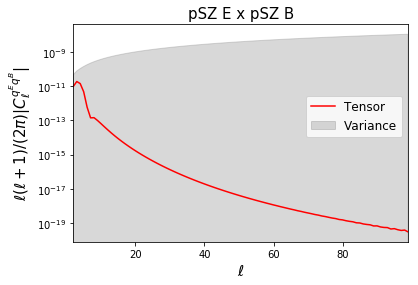

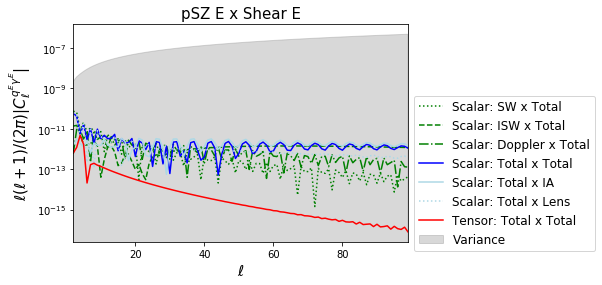

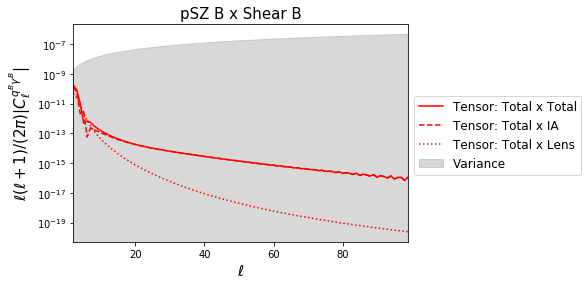

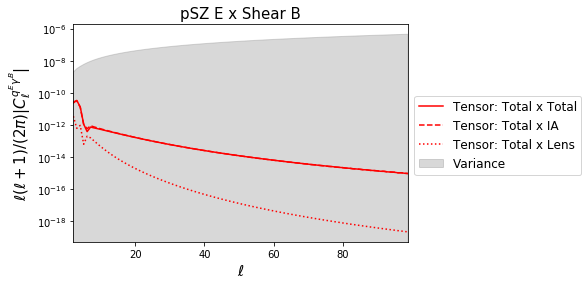

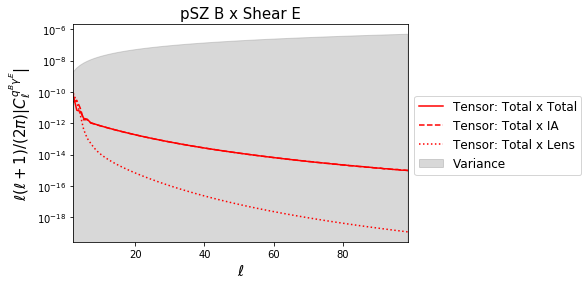

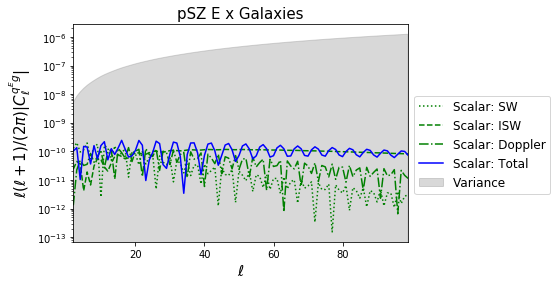

In [48]:
bin1 = 4
bin2 = 4
dl = np.diff(l_arr).mean()
print("Bins: %d x %d"%(bin1+1,bin2+1))

pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Shear E x Shear E',fontsize=15)
Cl_err = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_gEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_gEgE[bin1,bin1]-Cl_err),pref*(Cl_gEgE[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*Cl_gEgE_scalar_IA[bin1,bin2],label='Scalar: IA',c='b',ls=':')
plt.plot(l_arr,pref*Cl_gEgE_scalar_lens[bin1,bin2],label='Scalar: Lensing',c='b',ls='--')
plt.plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.plot(l_arr,pref*Cl_gEgE_tensor_IA[bin1,bin2],label='Tensor: IA',c='r',ls=':')
plt.plot(l_arr,pref*Cl_gEgE_tensor_lens[bin1,bin2],label='Tensor: Lensing',c='r',ls='--')
plt.plot(l_arr,pref*Cl_gEgE_tensor_tot[bin1,bin2],label='Tensor: Total',c='r',ls='-')
plt.plot(l_arr,pref*Cl_gEgE_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('Shear B x Shear B',fontsize=15)
Cl_err = np.sqrt((Cl_gBgB[bin1,bin1]*Cl_gBgB[bin2,bin2]+Cl_gBgB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_gBgB[bin1,bin1]-Cl_err),pref*(Cl_gBgB[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*Cl_gBgB_tensor_IA[bin1,bin2],label='Tensor: IA',c='r',ls=':')
plt.plot(l_arr,pref*Cl_gBgB_tensor_lens[bin1,bin2],label='Tensor: Lensing',c='r',ls='--')
plt.plot(l_arr,pref*Cl_gBgB_tensor_tot[bin1,bin2],label='Tensor: Total',c='r',ls='-')
plt.plot(l_arr,pref*Cl_gBgB_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^B\gamma^B}$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('Shear E x Shear B',fontsize=15)
Cl_err = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gBgB[bin2,bin2]+Cl_gEgB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_gEgB[bin1,bin1]-Cl_err),pref*(Cl_gEgB[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_gEgB_tensor_IA[bin1,bin2]),label='Tensor: IA',c='r',ls=':')
plt.plot(l_arr,pref*np.abs(Cl_gEgB_tensor_lens[bin1,bin2]),label='Tensor: Lensing',c='r',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_gEgB_tensor_tot[bin1,bin2]),label='Tensor: Total',c='r',ls='-')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{\gamma^E\gamma^B}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ E x pSZ E',fontsize=15)
Cl_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_qEqE[bin2,bin2]+Cl_qEqE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qEqE[bin1,bin1]-Cl_err),pref*(Cl_qEqE[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*Cl_qEqE_scalar_SW[bin1,bin2],label='Scalar: SW',c='g',ls=':')
plt.plot(l_arr,pref*Cl_qEqE_scalar_ISW[bin1,bin2],label='Scalar: ISW',c='g',ls='--')
plt.plot(l_arr,pref*Cl_qEqE_scalar_ISW[bin1,bin2],label='Scalar: Doppler',c='g',ls='-.')
plt.plot(l_arr,pref*Cl_qEqE_scalar_tot[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.plot(l_arr,pref*Cl_qEqE_tensor[bin1,bin2],label='Tensor',c='r',ls='-')
plt.plot(l_arr,pref*Cl_qEqE_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{q^Eq^E}$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ B x pSZ B',fontsize=15)
Cl_err = np.sqrt((Cl_qBqB[bin1,bin1]*Cl_qBqB[bin2,bin2]+Cl_qBqB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qBqB[bin1,bin1]-Cl_err),pref*(Cl_qBqB[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*Cl_qBqB_tensor[bin1,bin2],label='Tensor',c='r',ls='-')
plt.plot(l_arr,pref*Cl_qBqB_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{q^Bq^B}$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ E x pSZ B',fontsize=15)
Cl_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_qBqB[bin2,bin2]+Cl_qEqB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qEqB[bin1,bin1]-Cl_err),pref*(Cl_qEqB[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_qEqB_tensor[bin1,bin2]),label='Tensor',c='r',ls='-')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{q^Eq^B}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ E x Shear E',fontsize=15)
Cl_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_qEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qEgE[bin1,bin1]-Cl_err),pref*(Cl_qEgE[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_qEgE_scalar_SW)[bin1,bin2],label='Scalar: SW x Total',c='g',ls=':')
plt.plot(l_arr,pref*np.abs(Cl_qEgE_scalar_ISW)[bin1,bin2],label='Scalar: ISW x Total',c='g',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_qEgE_scalar_Doppler)[bin1,bin2],label='Scalar: Doppler x Total',c='g',ls='-.')
plt.plot(l_arr,pref*np.abs(Cl_qEgE_scalar_tot)[bin1,bin2],label='Scalar: Total x Total',c='b',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_qEgE_scalar_IA)[bin1,bin2],label='Scalar: Total x IA',c='lightblue',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_qEgE_scalar_lens)[bin1,bin2],label='Scalar: Total x Lens',c='lightblue',ls=':')
plt.plot(l_arr,pref*np.abs(Cl_qEgE_tensor_tot)[bin1,bin2],label='Tensor: Total x Total',c='r',ls='-')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{q^E\gamma^E}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ B x Shear B',fontsize=15)
Cl_err = np.sqrt((Cl_qBqB[bin1,bin1]*Cl_gBgB[bin2,bin2]+Cl_qBgB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qBgB[bin1,bin1]-Cl_err),pref*(Cl_qBgB[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_qBgB_tensor_tot)[bin1,bin2],label='Tensor: Total x Total',c='r',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_qBgB_tensor_IA)[bin1,bin2],label='Tensor: Total x IA',c='r',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_qBgB_tensor_lens)[bin1,bin2],label='Tensor: Total x Lens',c='r',ls=':')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{q^B\gamma^B}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ E x Shear B',fontsize=15)
Cl_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_gBgB[bin2,bin2]+Cl_qEgB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qEgB[bin1,bin1]-Cl_err),pref*(Cl_qEgB[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_qEgB_tensor_tot[bin1,bin2]),label='Tensor: Total x Total',c='r',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_qEgB_tensor_IA[bin1,bin2]),label='Tensor: Total x IA',c='r',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_qEgB_tensor_lens[bin1,bin2]),label='Tensor: Total x Lens',c='r',ls=':')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{q^E\gamma^B}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ B x Shear E',fontsize=15)
Cl_err = np.sqrt((Cl_qBqB[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_qBgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qBgE[bin1,bin1]-Cl_err),pref*(Cl_qBgE[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_qBgE_tensor_tot[bin1,bin2]),label='Tensor: Total x Total',c='r',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_qBgE_tensor_IA[bin1,bin2]),label='Tensor: Total x IA',c='r',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_qBgE_tensor_lens[bin1,bin2]),label='Tensor: Total x Lens',c='r',ls=':')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{q^B\gamma^E}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('pSZ E x Galaxies',fontsize=15)
Cl_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_gg[bin2,bin2]+Cl_qEg[bin1,bin2]*Cl_gqE[bin1,bin2])/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_qEg[bin1,bin1]-Cl_err),pref*(Cl_qEg[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_qEg_scalar_SW)[bin1,bin2],label='Scalar: SW',c='g',ls=':')
plt.plot(l_arr,pref*np.abs(Cl_qEg_scalar_ISW)[bin1,bin2],label='Scalar: ISW',c='g',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_qEg_scalar_Doppler)[bin1,bin2],label='Scalar: Doppler',c='g',ls='-.')
plt.plot(l_arr,pref*np.abs(Cl_qEg_scalar_tot)[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{q^Eg}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

## Paper Plots
- Plot the main auto- and cross-spectra for a single redshift bin.
- Spectra are shown in $\mu K^2$ units, multiplied by $\ell(\ell+1)/(2\pi)$
- We plot errors both for a realistic case with Euclid galaxy densities and $1\mu K$-arcmin noise, and the most optimistic case, with zero CMB and galaxy survey noise. Note that the reconstructed quadrupole has a noise term in both cases, due to cosmic variance. Note that we do not include tensors for the errors, thus the $B$-mode spectra have arbitrarily tight errorbars.

In [49]:
bin1 = 2
bin2 = 2
if opt_errors:
    gEgE_errOp = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_gEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    gBgB_errOp = np.sqrt((Cl_gBgB[bin1,bin1]*Cl_gBgB[bin2,bin2]+Cl_gBgB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qEqE_errOp = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_qEqE[bin2,bin2]+Cl_qEqE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qBqB_errOp = np.sqrt((Cl_qBqB[bin1,bin1]*Cl_qBqB[bin2,bin2]+Cl_qBqB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qEgE_errOp = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_qEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qBgB_errOp = np.sqrt((Cl_qBqB[bin1,bin1]*np.abs(Cl_gBgB[bin2,bin2]+Cl_qBgB[bin1,bin2]**2))/(f_sky*dl*(2.*l_arr+1.)))
else:
    gEgE_err = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_gEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    gBgB_err = np.sqrt((Cl_gBgB[bin1,bin1]*Cl_gBgB[bin2,bin2]+Cl_gBgB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qEqE_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_qEqE[bin2,bin2]+Cl_qEqE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qBqB_err = np.sqrt((Cl_qBqB[bin1,bin1]*Cl_qBqB[bin2,bin2]+Cl_qBqB[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qEgE_err = np.sqrt((Cl_qEqE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_qEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
    qBgB_err = np.sqrt((Cl_qBqB[bin1,bin1]*np.abs(Cl_gBgB[bin2,bin2]+Cl_qBgB[bin1,bin2]**2))/(f_sky*dl*(2.*l_arr+1.)))

Bins: 3 x 3
Average z = 1.2


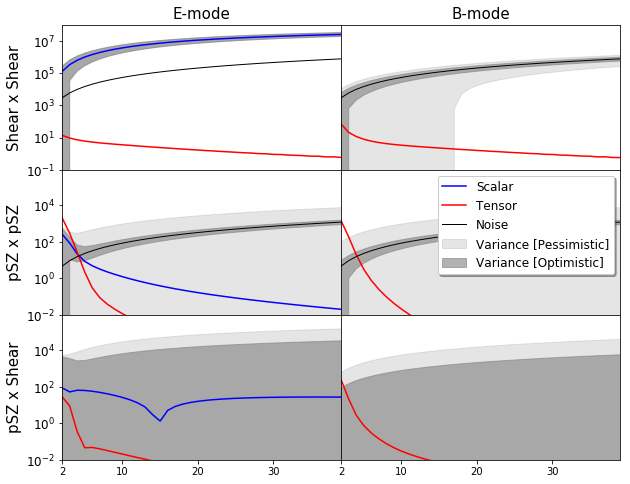

In [311]:
dl = np.diff(l_arr).mean()
print("Bins: %d x %d"%(bin1+1,bin2+1))
print(r'Average z = %.1f'%simps(n_chis[bin1]*z_arr,chi_arr))

fig,ax=plt.subplots(3,2,sharex=True,figsize=(10,8))
plt.subplots_adjust(hspace=0,wspace=0)
plt.xlim([0,10])

pref = l_arr*(l_arr+1.)/(2.*np.pi)*T_cmb**2.*1e12
ax[0,0].set_title('E-mode',fontsize=15)
ax[0,1].set_title('B-mode',fontsize=15)

rT_rescale = 1./rT_fid
a1 = 0.2
a2 = 0.6
lw = 1.

# gEgE
ax[0,0].plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Scalar',c='b',ls='-')
ax[0,0].plot(l_arr,rT_rescale*pref*Cl_gEgE_tensor_tot[bin1,bin2],label='Tensor [r=1]',c='r',ls='-')
ax[0,0].fill_between(l_arr,pref*(Cl_gEgE[bin1,bin2]-gEgE_err),pref*(Cl_gEgE[bin1,bin2]+gEgE_err),label='Variance',color='gray',alpha=a1)
ax[0,0].fill_between(l_arr,pref*(Cl_gEgE[bin1,bin2]-gEgE_errOp),pref*(Cl_gEgE[bin1,bin2]+gEgE_errOp),label='Variance',color='gray',alpha=a2)
ax[0,0].plot(l_arr,pref*Cl_gEgE_noise[bin1,bin2],label='Noise',c='k',lw=lw)
# gBgB
ax[0,1].fill_between(l_arr,pref*(Cl_gBgB[bin1,bin1]-gBgB_err),pref*(Cl_gBgB[bin1,bin1]+gBgB_err),color='gray',alpha=a1)
ax[0,1].fill_between(l_arr,pref*(Cl_gBgB[bin1,bin1]-gBgB_errOp),pref*(Cl_gBgB[bin1,bin1]+gBgB_errOp),color='gray',alpha=a2)
ax[0,1].plot(l_arr,pref*rT_rescale*Cl_gBgB_tensor_tot[bin1,bin2],c='r',ls='-')
ax[0,1].plot(l_arr,pref*Cl_gBgB_noise[bin1,bin2],c='k',lw=lw)

# qEqE
ax[1,0].plot(l_arr,pref*Cl_qEqE_scalar_tot[bin1,bin2],c='b',ls='-')
ax[1,0].plot(l_arr,rT_rescale*pref*Cl_qEqE_tensor[bin1,bin2],c='r',ls='-')
ax[1,0].fill_between(l_arr,pref*(Cl_qEqE[bin1,bin1]-qEqE_err),pref*(Cl_qEqE[bin1,bin1]+qEqE_err),color='gray',alpha=a1)
ax[1,0].fill_between(l_arr,pref*(Cl_qEqE[bin1,bin1]-qEqE_errOp),pref*(Cl_qEqE[bin1,bin1]+qEqE_errOp),color='gray',alpha=a2)
ax[1,0].plot(l_arr,pref*Cl_qEqE_noise[bin1,bin2],c='k',lw=lw)
# qBqB
ax[1,1].fill_between(l_arr,pref*(Cl_qBqB[bin1,bin1]-qBqB_err),pref*(Cl_qBqB[bin1,bin1]+qBqB_err),
                     label='Variance [Pessimistic]',color='gray',alpha=a1)
ax[1,1].fill_between(l_arr,pref*(Cl_qBqB[bin1,bin1]-qBqB_errOp),pref*(Cl_qBqB[bin1,bin1]+qBqB_errOp),
                     label='Variance [Optimistic]',color='gray',alpha=a2)
ax[1,1].plot(l_arr,0.*l_arr,color='b',ls='-',label='Scalar')
ax[1,1].plot(l_arr,pref*rT_rescale*Cl_qBqB_tensor[bin1,bin2],c='r',ls='-',label='Tensor')
ax[1,1].plot(l_arr,pref*Cl_qBqB_noise[bin1,bin2],c='k',label='Noise',lw=lw)

# qEgE
ax[2,0].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_tot[bin1,bin2]),c='b',ls='-')
ax[2,0].plot(l_arr,rT_rescale*pref*np.abs(Cl_qEgE_tensor_tot[bin1,bin2]),c='r',ls='-')
ax[2,0].fill_between(l_arr,pref*(Cl_qEgE[bin1,bin1]-qEgE_err),pref*(Cl_qEgE[bin1,bin1]+qEgE_err),color='gray',alpha=a1)
ax[2,0].fill_between(l_arr,pref*(Cl_qEgE[bin1,bin1]-qEgE_errOp),pref*(Cl_qEgE[bin1,bin1]+qEgE_errOp),color='gray',alpha=a2)
# qBgB
ax[2,1].fill_between(l_arr,pref*(Cl_qBgB[bin1,bin1]-qBgB_err),pref*(Cl_qBgB[bin1,bin1]+qBgB_err),color='gray',alpha=a1)
ax[2,1].fill_between(l_arr,pref*(Cl_qBgB[bin1,bin1]-qBgB_errOp),pref*(Cl_qBgB[bin1,bin1]+qBgB_errOp),color='gray',alpha=a2)
ax[2,1].plot(l_arr,pref*rT_rescale*np.abs(Cl_qBgB_tensor_tot[bin1,bin2]),c='r',ls='-')

ax[0,0].set_xlabel(r'$\ell$',fontsize=15)
ax[0,0].set_ylabel(r'Shear x Shear',fontsize=15)
ax[1,0].set_ylabel(r'pSZ x pSZ',fontsize=15)
ax[2,0].set_ylabel(r'pSZ x Shear',fontsize=15)
for i in range(3):
    ax[i,1].set_yscale('log')
    ax[i,0].tick_params(axis='y', labelsize=12)
    ax[i,0].set_yscale('log')
for j in range(2):
    ax[0,j].tick_params(axis='x', labelsize=12)
    ax[0,j].set_ylim([1e-1,1e8])
    ax[1,j].set_ylim([1e-2,9e5])
    ax[2,j].set_ylim([1e-2,9e5])
ax[0,0].set_xlim([min(l_arr),39])
ax[0,1].set_xlim([min(l_arr),39])
ax[0,0].set_xticks([2,10,20,30])
for i in range(3):
    ax[i,1].set_yticks([])
    ax[i,1].set_yticks([],minor=True)
ax[1,1].legend(fontsize=12,fancybox=True,shadow=True,ncol=1);
fig.savefig('combined_EB_plot.pdf',bbox_inches='tight')

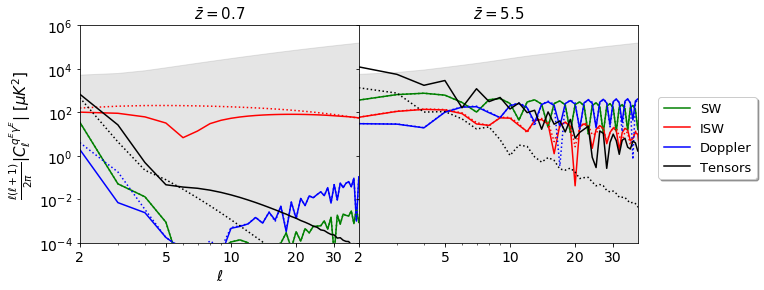

In [51]:
binA = 1
binB = 5
dl = np.diff(l_arr).mean()

fig,ax=plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,4))
plt.subplots_adjust(hspace=0,wspace=0)
plt.xlim([0,10])

pref = l_arr*(l_arr+1.)/(2.*np.pi)*T_cmb**2.*1e12

ax[0].set_title(r'$\bar z = %.1f$'%simps(n_chis[binA]*z_arr,chi_arr),fontsize=15)
ax[1].set_title(r'$\bar z = %.1f$'%simps(n_chis[binB]*z_arr,chi_arr),fontsize=15)

rT_rescale = 10
a1 = 0.2
lw = 1.

for i,bin1,bin2 in zip(range(2),[binA,binB],[binA,binB]):
    
    # full shear
    ax[i].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_SW[bin1,bin2]),c='g',ls='-',label='SW')
    ax[i].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_ISW[bin1,bin2]),c='r',ls='-',label='ISW')
    ax[i].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_Doppler[bin1,bin2]),c='b',ls='-',label='Doppler')

    # lensing-only
    ax[i].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_SW[bin1,bin2]),c='g',ls=':')
    ax[i].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_ISW_lens[bin1,bin2]),c='r',ls=':')
    ax[i].plot(l_arr,pref*np.abs(Cl_qEgE_scalar_Doppler_lens[bin1,bin2]),c='b',ls=':')

    
    # full shear
    ax[i].plot(l_arr,rT_rescale*pref*np.abs(Cl_qEgE_tensor_tot[bin1,bin2]),c='k',ls='-',label=r'Tensors')
    
    # lensing-only
    ax[i].plot(l_arr,rT_rescale*pref*np.abs(Cl_qEgE_tensor_lens[bin1,bin2]),c='k',ls=':')
    
    
    # errors
    ax[i].fill_between(l_arr,pref*(Cl_qEgE[bin1,bin1]-qEgE_err),pref*(Cl_qEgE[bin1,bin1]+qEgE_err),color='gray',alpha=a1)
    
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}\left|C_\ell^{q^E\gamma^E}\right|$ [$\mu K^2$]',fontsize=15)
ax[1].set_yscale('log')
ax[0].tick_params(axis='y', labelsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)

ax[0].set_xlim([2,39])
ax[0].set_ylim([1e-4,1e6])
ax[1].set_yticks([])
ax[1].set_yticks([],minor=True)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xticks([2,5,10,20,30])
ax[1].set_xticks([2,5,10,20,30])
ax[0].set_xticklabels([2,5,10,20,30])
ax[1].set_xticklabels([2,5,10,20,30])
ax[0].legend(fontsize=13,fancybox=True,shadow=True,ncol=1,bbox_to_anchor=(2.45,0.7));
fig.savefig('contributions_qg.pdf',bbox_inches='tight')

# Fisher Forecasts

Below we forecast the S/N of the following quantities:
- pSZ auto-spectra
- pSZ x lensing cross-spectra
- Detectability of ISW effect
- Detectability of SW effect
- Detectability of Doppler effect
- Detectability of GWs from shear [NB: probably feasible in practice due to systematics?]
- Detectability of GWs from pSZ
- Detectability of GWs from shear x pSZ
- Detectability of odd-parity GWs from the above probes.

- It is also interesting to forecast dependence on the z-binning and CMB / galaxy noise parameters.

#### Parity-even forecast

In [52]:
# Construct matrix of all spectra
Cls = np.asarray([[Cl_gEgE,Cl_gEgB,Cl_gEqE,Cl_gEqB,0.*Cl_qEg],
                  [Cl_gBgE,Cl_gBgB,Cl_gBqE,Cl_gBqB,0.*Cl_qEg],
                  [Cl_qEgE,Cl_qEgB,Cl_qEqE,Cl_qEqB,Cl_qEg],
                  [Cl_qBgE,Cl_qBgB,Cl_qBqE,Cl_qBqB,0.*Cl_qEg],
                  [0.*Cl_gqE,0.*Cl_gqE,Cl_gqE,0.*Cl_gqE,Cl_gg]])

def cross_covariance_factor(X,Y,Z,W,a,b,c,d):
    """X etc. are {0,1} for {gE, gB, Fg, Fc}
    a etc. are bin indices"""
    out = Cls[X,Z][a,c]*Cls[Y,W][b,d]+Cls[X,W][a,d]*Cls[Y,Z][b,c]
    return out

# Construct cross-covariance matrix for any ell and all shear + pSZ statistics (parity-even)
cross_covariances_all = np.zeros((n_tomo*(n_tomo+1)*4-2*n_tomo,n_tomo*(n_tomo+1)*4-2*n_tomo,len(l_arr)))
ii = 0
dl = np.diff(l_arr).mean()
assert(np.diff(l_arr).var()<1e-10)
for X,Y in [[0,0],[0,2],[1,1],[1,3],[2,0],[2,2],[3,1],[3,3]]:
    #        gEgE, gEqE, gBgB, gBqB, qEgE, qEqE, qBgB, qBqB 
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[0,0],[0,2],[1,1],[1,3],[2,0],[2,2],[3,1],[3,3]]:
                #        gEgE, gEqE, gBgB, gBqB, qEgE, qEqE, qBgB, qBqB 
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_all[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1

# Construct cross-covariance matrix for any ell and cross shear-pSZ statistics (parity-even)
cross_covariances_cross = np.zeros((n_tomo*(n_tomo+1)*2-2*n_tomo,n_tomo*(n_tomo+1)*2-2*n_tomo,len(l_arr)))
ii = 0
dl = np.diff(l_arr).mean()
assert(np.diff(l_arr).var()<1e-10)
for X,Y in [[0,2],[1,3],[2,0],[3,1]]:
    #        gEqE, gBqB, qEgE, qBgB 
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[0,2],[1,3],[2,0],[3,1]]:
                #        gEqE, gBqB, qEgE, qBgB 
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_cross[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and shear-only statistics (parity-even)
cross_covariances_g = np.zeros((n_tomo*(n_tomo+1),n_tomo*(n_tomo+1),len(l_arr)))
ii = 0
for X,Y in [[0,0],[1,1]]:
    # gEgE, gBgB
    for a in range(n_tomo):
        for b in range(a,n_tomo):
            jj = 0
            for Z,W in [[0,0],[1,1]]:
                # gEgE, gBgB
                for c in range(n_tomo):
                    for d in range(c,n_tomo):
                        cross_covariances_g[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and pSZ-only statistics (parity-even)
cross_covariances_q = np.zeros((n_tomo*(n_tomo+1),n_tomo*(n_tomo+1),len(l_arr)))
ii = 0
for X,Y in [[2,2],[3,3]]:
    # qEqE, qBgB
    for a in range(n_tomo):
        for b in range(a,n_tomo):
            jj = 0
            for Z,W in [[2,2],[3,3]]:
                # qEqE, qBqB
                for c in range(n_tomo):
                    for d in range(c,n_tomo):
                        cross_covariances_q[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and gal/pSZ-E statistics (parity-even)
cross_covariances_gal = np.zeros((n_tomo**2,n_tomo**2,len(l_arr)))
ii = 0
for X,Y in [[2,4],[4,2]]:
    # qEg, gqE
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[2,4],[4,2]]:
                # qEg, gqE
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_gal[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1

In [58]:
def compute_fisher_shear(signal,fid_val=1.):
    """Compute Fisher matrix from shear for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [gEgE, gBgB]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_g[:,:,l_i]#[:n_tomo*(n_tomo+1),:n_tomo*(n_tomo+1),l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1))

        # Assemble matrices
        ii = 0
        for j in range(2):
            for a in range(n_tomo):
                for b in range(a,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_pSZ(signal,fid_val=1.):
    """Compute Fisher matrix from pSZ for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [qEqE, qBqB]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_q[:,:,l_i]#[:n_tomo*(n_tomo+1),:n_tomo*(n_tomo+1),l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1))

        # Assemble matrices
        ii = 0
        for j in range(2):
            for a in range(n_tomo):
                for b in range(a,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_cross(signal,fid_val=1.):
    """Compute Fisher matrix from shear x pSZ for a given input signal vector (without auto-spectra).
    
    The derivative vector is the desired signal in the following configurations: [gEqE, gBqB, qEgE, qBgB]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_cross[:,:,l_i]#[:n_tomo*(n_tomo+1)*2-2*n_tomo,:n_tomo*(n_tomo+1)*2-2*n_tomo,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)*2-2*n_tomo)

        # Assemble matrices
        ii = 0
        for j in range(4):
            # skip i=j bin if already counted
            if j==2 or j==3:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_gal_cross(signal,fid_val=1.):
    """Compute Fisher matrix from galaxies x pSZ for a given input signal vector (without auto-spectra).
    
    The derivative vector is the desired signal in the following configurations: [gEg, ggE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_gal[:,:,l_i]#[:n_tomo*(n_tomo+1)*4-2*n_tomo,:n_tomo*(n_tomo+1)*4-2*n_tomo,l_i]
        Sl_vec = np.zeros(n_tomo**2)
        
        # Assemble matrices
        ii = 0
        for j in range(2):
            # skip i=j bin if already counted
            if j==1:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher(signal,fid_val=1.):
    """Compute Fisher matrix from shear and pSZ for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [gEgE, gEqE, gBgB, gBqB, qEgE, qEqE, qBgB, qBqB]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_all[:,:,l_i]#[:n_tomo*(n_tomo+1)*4-2*n_tomo,:n_tomo*(n_tomo+1)*4-2*n_tomo,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)*4-2*n_tomo)

        # Assemble matrices
        ii = 0
        for j in range(8):
            # skip i=j bin if already counted
            if j==4 or j==6:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

### Scalar S/N forecasts
- Here, we simply compute the S/N of the various spectra, i.e. writing $C_\ell^{XY}\to\alpha\,C_\ell^{XY}$ and forecasting the constraints on $\alpha$ as a function of $\ell$.

In [306]:
assert(shear_signal==False)
assert(psz_signal==False)

print("shear lens")
fish_gg_lens=compute_fisher_shear([Cl_gEgE_scalar_lens,0],fid_val=1.)
print("shear IA")
fish_gg_IA=compute_fisher_shear([Cl_gEgE_scalar_IA,0],fid_val=1.)
print("shear total")
fish_gg_tot=compute_fisher_shear([Cl_gEgE_scalar_tot,0],fid_val=1.)

print("")
print("pSZ SW")
fish_qq_SW=compute_fisher_pSZ([Cl_qEqE_scalar_SW,0],fid_val=1.)
print("pSZ ISW")
fish_qq_ISW=compute_fisher_pSZ([Cl_qEqE_scalar_ISW,0],fid_val=1.)
print("pSZ Doppler")
fish_qq_Doppler=compute_fisher_pSZ([Cl_qEqE_scalar_Doppler,0],fid_val=1.)
print("pSZ total")
fish_qq_tot=compute_fisher_pSZ([Cl_qEqE_scalar_tot,0],fid_val=1.)

print("")
print("shear-cross total/lens")
fish_cross_tot_lens=compute_fisher_cross([np.swapaxes(Cl_qEgE_scalar_lens,0,1),0,Cl_qEgE_scalar_lens,0],fid_val=1.)
print("shear-cross total/IA")
fish_cross_tot_IA=compute_fisher_cross([np.swapaxes(Cl_qEgE_scalar_IA,0,1),0,Cl_qEgE_scalar_IA,0],fid_val=1.)
print("shear-cross total/total")
fish_cross_tot_tot=compute_fisher_cross([np.swapaxes(Cl_qEgE_scalar_tot,0,1),0,Cl_qEgE_scalar_tot,0],fid_val=1.)
print("shear-cross SW/total")
fish_cross_tot_SW=compute_fisher_cross([np.swapaxes(Cl_qEgE_scalar_SW,0,1),0,Cl_qEgE_scalar_SW,0],fid_val=1.)
print("shear-cross ISW/total")
fish_cross_tot_ISW=compute_fisher_cross([np.swapaxes(Cl_qEgE_scalar_ISW,0,1),0,Cl_qEgE_scalar_ISW,0],fid_val=1.)
print("shear-cross Doppler/total")
fish_cross_tot_Doppler=compute_fisher_cross([np.swapaxes(Cl_qEgE_scalar_Doppler,0,1),0,Cl_qEgE_scalar_Doppler,0],fid_val=1.)

print("")
print("gal-cross total/total")
fish_gal_cross_tot_tot=compute_fisher_gal_cross([Cl_qEg_scalar_tot,Cl_qEg_scalar_tot.swapaxes(0,1)],fid_val=1.)
print("gal-cross SW/total")
fish_gal_cross_tot_SW=compute_fisher_gal_cross([Cl_qEg_scalar_SW,Cl_qEg_scalar_SW.swapaxes(0,1)],fid_val=1.)
print("gal-cross ISW/total")
fish_gal_cross_tot_ISW=compute_fisher_gal_cross([Cl_qEg_scalar_ISW,Cl_qEg_scalar_ISW.swapaxes(0,1)],fid_val=1.)
print("gal-cross Doppler/total")
fish_gal_cross_tot_Doppler=compute_fisher_gal_cross([Cl_qEg_scalar_Doppler,Cl_qEg_scalar_Doppler.swapaxes(0,1)],fid_val=1.)

shear lens
1-sigma bound: 0.000, Fiducial: 1.00e+00, S/N: 2132.461
shear IA
1-sigma bound: 0.006, Fiducial: 1.00e+00, S/N: 180.188
shear total
1-sigma bound: 0.001, Fiducial: 1.00e+00, S/N: 1944.521

pSZ SW
1-sigma bound: 0.006, Fiducial: 1.00e+00, S/N: 177.916
pSZ ISW
1-sigma bound: 0.127, Fiducial: 1.00e+00, S/N: 7.855
pSZ Doppler
1-sigma bound: 1.309, Fiducial: 1.00e+00, S/N: 0.764
pSZ total
1-sigma bound: 0.008, Fiducial: 1.00e+00, S/N: 118.796

shear-cross total/lens
1-sigma bound: 0.127, Fiducial: 1.00e+00, S/N: 7.849
shear-cross total/IA
1-sigma bound: 0.457, Fiducial: 1.00e+00, S/N: 2.189
shear-cross total/total
1-sigma bound: 0.141, Fiducial: 1.00e+00, S/N: 7.102
shear-cross SW/total
1-sigma bound: 0.218, Fiducial: 1.00e+00, S/N: 4.580
shear-cross ISW/total
1-sigma bound: 0.138, Fiducial: 1.00e+00, S/N: 7.256
shear-cross Doppler/total
1-sigma bound: 3.591, Fiducial: 1.00e+00, S/N: 0.278

gal-cross total/total
1-sigma bound: 0.497, Fiducial: 1.00e+00, S/N: 2.012
gal-cross SW/to

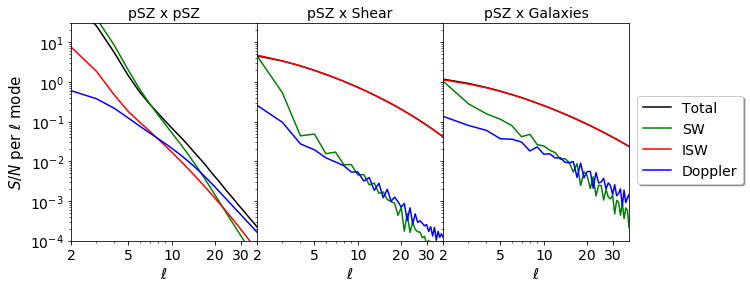

In [307]:
fig,ax = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(l_arr,np.sqrt(dl*fish_qq_tot),label='Total',c='k',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_qq_SW),label='SW',c='g',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_qq_ISW),label='ISW',c='r',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_qq_Doppler),label='Doppler',c='b',ls='-')
ax[0].set_title('pSZ x pSZ',fontsize=14)
ax[0].set_ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim([1e-4,30])
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_tot),label='Total',c='k',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_SW),label='SW',c='g',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_ISW),label='ISW',c='r',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_Doppler),label='Doppler',c='b',ls='-')
ax[1].set_title('pSZ x Shear',fontsize=14)

ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_tot),label='Total',c='k',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_SW),label='SW',c='g',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_ISW),label='ISW',c='r',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_Doppler),label='Doppler',c='b',ls='-')
ax[2].set_title('pSZ x Galaxies',fontsize=14)

ax[0].set_xlim([2,39])
for j in range(3):
    ax[j].set_xticklabels([2,5,10,20,30])
    ax[j].set_xticks([2,5,10,20,30])
    ax[j].set_xlabel(r'$\ell$',fontsize=15)
    ax[j].tick_params(axis='x', labelsize=14)

ax[0].legend(fontsize=14,fancybox=True,shadow=True,ncol=1,bbox_to_anchor=(3.65,0.7));
fig.savefig('SN_scalar.pdf',bbox_inches='tight')

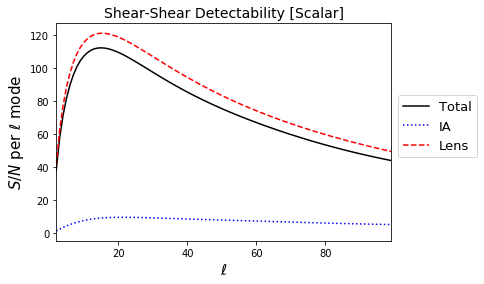

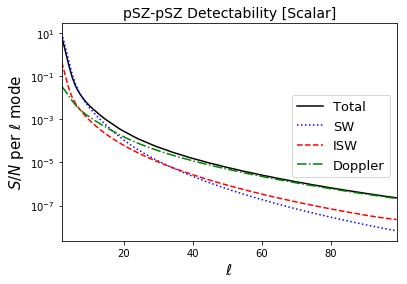

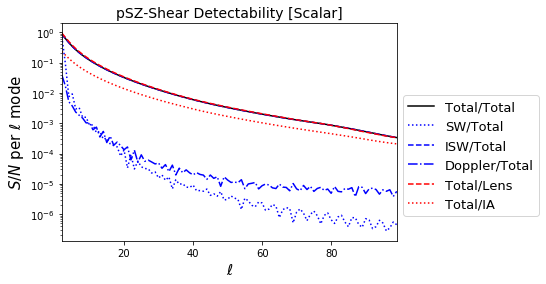

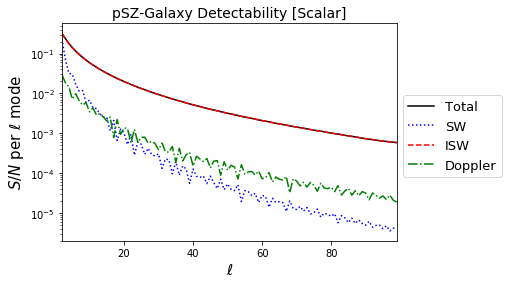

In [94]:
plt.plot(l_arr,np.sqrt(dl*fish_gg_tot),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_gg_IA),label='IA',ls=':',c='b')
plt.plot(l_arr,np.sqrt(dl*fish_gg_lens),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('Shear-Shear Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);

plt.figure()
plt.plot(l_arr,np.sqrt(dl*fish_qq_tot),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_qq_SW),label='SW',c='b',ls=':')
plt.plot(l_arr,np.sqrt(dl*fish_qq_ISW),label='ISW',c='r',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_qq_Doppler),label='Doppler',c='g',ls='-.')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-pSZ Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
plt.yscale('log');

plt.figure()
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_tot),label='Total/Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_SW),label='SW/Total',c='b',ls=':')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_ISW),label='ISW/Total',c='b',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_Doppler),label='Doppler/Total',c='b',ls='-.')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_lens),label='Total/Lens',c='r',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_IA),label='Total/IA',c='r',ls=':')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-Shear Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
plt.yscale('log');

plt.figure()
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_tot),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_SW),label='SW',c='b',ls=':')
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_ISW),label='ISW',c='r',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_Doppler),label='Doppler',c='g',ls='-.')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-Galaxy Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
plt.yscale('log');

### pSZ Component Forecasts
- Here we forecast the errors on each pSZ component (a) from pSZ x pSZ, (b) from shear + pSZ and (c) from galaxies + pSZ
- We write $q^{E,B} \sim \alpha\,q^{E,B,\rm fid}$ and constrain $\alpha$ relative to a fiducial $\alpha=1$.
- This is needed to constrain cross-terms properly.

In [313]:
print("SW")
fish_qq_SW=compute_fisher_pSZ([Cl_qEqE_scalar_SW,0],fid_val=1.)
fish_joint_SW=compute_fisher([0,np.swapaxes(Cl_qEgE_scalar_SW,0,1)/np.sqrt(2.),0,0,Cl_qEgE_scalar_SW/np.sqrt(2.),Cl_qEqE_scalar_SW,0,0],fid_val=1)
print("ISW")
fish_qq_ISW=compute_fisher_pSZ([Cl_qEqE_scalar_ISW,0],fid_val=1.)
fish_joint_ISW=compute_fisher([0,np.swapaxes(Cl_qEgE_scalar_ISW,0,1)/np.sqrt(2.),0,0,Cl_qEgE_scalar_ISW/np.sqrt(2.),Cl_qEqE_scalar_ISW,0,0],fid_val=1)
print("Doppler")
fish_qq_Doppler=compute_fisher_pSZ([Cl_qEqE_scalar_Doppler,0],fid_val=1.)
fish_joint_Doppler=compute_fisher([0,np.swapaxes(Cl_qEgE_scalar_Doppler,0,1)/np.sqrt(2.),0,0,Cl_qEgE_scalar_Doppler/np.sqrt(2.),Cl_qEqE_scalar_Doppler,0,0],fid_val=1)
print("total")
fish_qq_tot=compute_fisher_pSZ([Cl_qEqE_scalar_tot,0],fid_val=1.)
fish_joint_tot=compute_fisher([0,np.swapaxes(Cl_qEgE_scalar_tot,0,1)/np.sqrt(2.),0,0,Cl_qEgE_scalar_tot/np.sqrt(2.),Cl_qEqE_scalar_tot,0,0],fid_val=1)

SW
1-sigma bound: 0.006, Fiducial: 1.00e+00, S/N: 177.916
1-sigma bound: 0.006, Fiducial: 1.00e+00, S/N: 177.946
ISW
1-sigma bound: 0.127, Fiducial: 1.00e+00, S/N: 7.855
1-sigma bound: 0.107, Fiducial: 1.00e+00, S/N: 9.382
Doppler
1-sigma bound: 1.309, Fiducial: 1.00e+00, S/N: 0.764
1-sigma bound: 1.267, Fiducial: 1.00e+00, S/N: 0.789
total
1-sigma bound: 0.008, Fiducial: 1.00e+00, S/N: 118.796
1-sigma bound: 0.008, Fiducial: 1.00e+00, S/N: 118.902


Full: pSZ + Shear, Dotted: pSZ-only


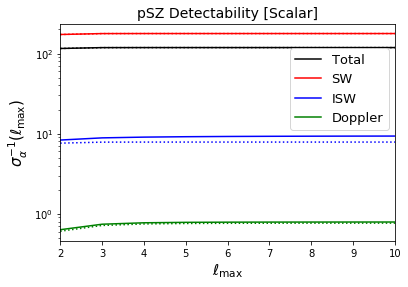

In [314]:
plt.figure()
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_tot)),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_qq_tot)),c='k',ls=':')
plt.xlim([min(l_arr),10])

plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_SW)),label='SW',c='r',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_qq_SW)),c='r',ls=':')

plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_ISW)),label='ISW',c='b',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_qq_ISW)),c='b',ls=':')

plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_Doppler)),label='Doppler',c='g',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_qq_Doppler)),c='g',ls=':')

plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
print("Full: pSZ + Shear, Dotted: pSZ-only")
plt.title('pSZ Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$\sigma_\alpha^{-1}(\ell_{\rm max})$',fontsize=15);
plt.yscale('log');

### Even Tensor Fisher forecasts

In [317]:
assert(shear_signal==True)
assert(psz_signal==True)

print("shear lens")
fish_gg_lens=compute_fisher_shear([Cl_gEgE_tensor_lens/rT_fid,Cl_gBgB_tensor_lens/rT_fid],fid_val=rT_fid)
print("shear IA")
fish_gg_IA=compute_fisher_shear([Cl_gEgE_tensor_IA/rT_fid,Cl_gBgB_tensor_IA/rT_fid],fid_val=rT_fid)
print("shear total")
fish_gg_tot=compute_fisher_shear([Cl_gEgE_tensor_tot/rT_fid,Cl_gBgB_tensor_tot/rT_fid],fid_val=rT_fid)

print("")
print("pSZ total")
fish_qq_tot=compute_fisher_pSZ([Cl_qEqE_tensor/rT_fid,Cl_qBqB_tensor/rT_fid],fid_val=rT_fid)

print("")
print("shear x pSZ lens")
fish_cross_lens=compute_fisher_cross([np.swapaxes(Cl_qEgE_tensor_lens,0,1)/rT_fid,
                                     np.swapaxes(Cl_qBgB_tensor_lens,0,1)/rT_fid,
                                     Cl_qEgE_tensor_lens/rT_fid,Cl_qBgB_tensor_lens/rT_fid],fid_val=rT_fid)
print("shear x pSZ IA")
fish_cross_IA=compute_fisher_cross([np.swapaxes(Cl_qEgE_tensor_IA,0,1)/rT_fid,
                                     np.swapaxes(Cl_qBgB_tensor_IA,0,1)/rT_fid,
                                     Cl_qEgE_tensor_IA/rT_fid,Cl_qBgB_tensor_IA/rT_fid],fid_val=rT_fid)
print("shear x pSZ total")
fish_cross_tot=compute_fisher_cross([np.swapaxes(Cl_qEgE_tensor_tot,0,1)/rT_fid,
                                     np.swapaxes(Cl_qBgB_tensor_tot,0,1)/rT_fid,
                                     Cl_qEgE_tensor_tot/rT_fid,Cl_qBgB_tensor_tot/rT_fid],fid_val=rT_fid)

print("")
print("shear + pSZ lens")
fish_joint_lens=compute_fisher([Cl_gEgE_tensor_lens/rT_fid,np.swapaxes(Cl_qEgE_tensor_lens,0,1)/rT_fid,
                                Cl_gBgB_tensor_lens/rT_fid,np.swapaxes(Cl_qBgB_tensor_lens,0,1)/rT_fid,
                                Cl_qEgE_tensor_lens/rT_fid,Cl_qEqE_tensor/rT_fid,
                                Cl_qBgB_tensor_lens/rT_fid,Cl_qBqB_tensor/rT_fid],fid_val=rT_fid)
print("shear + pSZ IA")
fish_joint_IA=compute_fisher([Cl_gEgE_tensor_IA/rT_fid,np.swapaxes(Cl_qEgE_tensor_IA,0,1)/rT_fid,
                                Cl_gBgB_tensor_IA/rT_fid,np.swapaxes(Cl_qBgB_tensor_IA,0,1)/rT_fid,
                                Cl_qEgE_tensor_IA/rT_fid,Cl_qEqE_tensor/rT_fid,
                                Cl_qBgB_tensor_IA/rT_fid,Cl_qBqB_tensor/rT_fid],fid_val=rT_fid)
print("shear + pSZ total")
fish_joint_tot=compute_fisher([Cl_gEgE_tensor_tot/rT_fid,np.swapaxes(Cl_qEgE_tensor_tot,0,1)/rT_fid,
                                Cl_gBgB_tensor_tot/rT_fid,np.swapaxes(Cl_qBgB_tensor_tot,0,1)/rT_fid,
                                Cl_qEgE_tensor_tot/rT_fid,Cl_qEqE_tensor/rT_fid,
                                Cl_qBgB_tensor_tot/rT_fid,Cl_qBqB_tensor/rT_fid],fid_val=rT_fid)

shear lens
1-sigma bound: 57.7470, Fiducial: 1.00e+00, S/N: 0.017
shear IA
1-sigma bound: 35.5266, Fiducial: 1.00e+00, S/N: 0.028
shear total
1-sigma bound: 20.3195, Fiducial: 1.00e+00, S/N: 0.049

pSZ total
1-sigma bound: 0.0009, Fiducial: 1.00e+00, S/N: 1174.940

shear x pSZ lens
1-sigma bound: 0.1656, Fiducial: 1.00e+00, S/N: 6.039
shear x pSZ IA
1-sigma bound: 0.1783, Fiducial: 1.00e+00, S/N: 5.609
shear x pSZ total
1-sigma bound: 0.1417, Fiducial: 1.00e+00, S/N: 7.055

shear + pSZ lens
1-sigma bound: 0.0009, Fiducial: 1.00e+00, S/N: 1174.955
shear + pSZ IA
1-sigma bound: 0.0009, Fiducial: 1.00e+00, S/N: 1174.953
shear + pSZ total
1-sigma bound: 0.0009, Fiducial: 1.00e+00, S/N: 1174.961


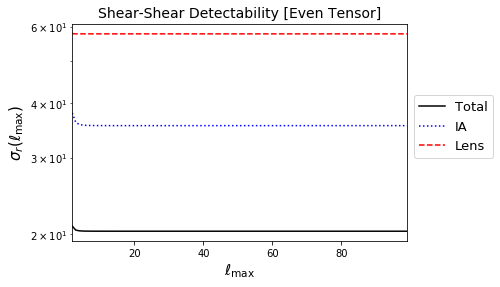

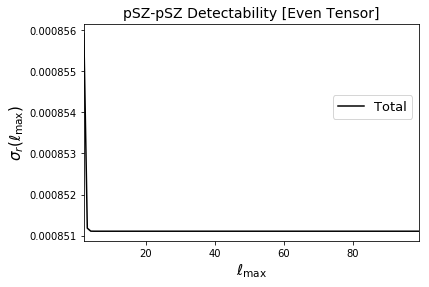

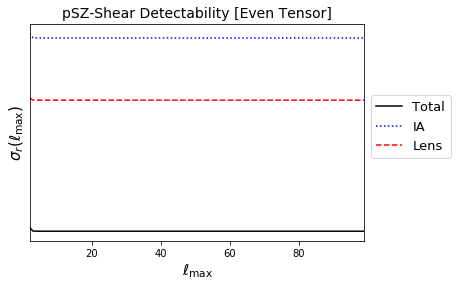

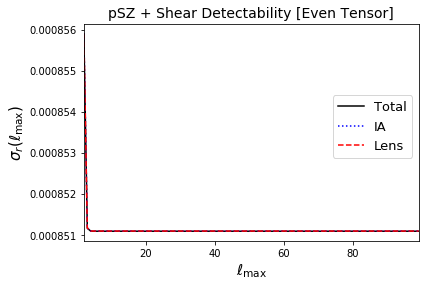

In [318]:
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_gg_tot))),label='Total',c='k',ls='-')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_gg_IA))),label='IA',ls=':',c='b')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_gg_lens))),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('Shear-Shear Detectability [Even Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
plt.yscale('log')

plt.figure()
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_qq_tot))),label='Total',c='k',ls='-')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-pSZ Detectability [Even Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
#plt.yscale('log')

plt.figure()
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_cross_tot))),label='Total',c='k',ls='-')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_cross_IA))),label='IA',ls=':',c='b')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_cross_lens))),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-Shear Detectability [Even Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
plt.yscale('log')

plt.figure()
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_joint_tot))),label='Total',c='k',ls='-')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_joint_IA))),label='IA',ls=':',c='b')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*fish_joint_lens))),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ + Shear Detectability [Even Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
#plt.yscale('log')

### Odd Tensor Forecasts

- Note that the parity-even and parity-odd parts are independent by parity-conservation.

In [59]:
# Construct cross-covariance matrix for any ell and all shear + pS statistics (parity-odd)
cross_covariances_all_odd = np.zeros((n_tomo*(n_tomo+1)*4-4*n_tomo,n_tomo*(n_tomo+1)*4-4*n_tomo,len(l_arr)))
ii = 0
for X,Y in [[0,1],[0,3],[1,0],[1,2],[2,1],[2,3],[3,0],[3,2]]:
    #        gEgB, gEqB, gBgE, gBqE, qEgB, qEqB, qBgE, qBqE 
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[0,1],[0,3],[1,0],[1,2],[2,1],[2,3],[3,0],[3,2]]:
                #        gEgB, gEqB, gBgE, gBqE, qEgB, qEqB, qBgE, qBqE 
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_all_odd[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and cross shear-pSZ statistics (parity-odd)
cross_covariances_cross_odd = np.zeros((n_tomo*(n_tomo+1)*2-2*n_tomo,n_tomo*(n_tomo+1)*2-2*n_tomo,len(l_arr)))
ii = 0
dl = np.diff(l_arr).mean()
assert(np.diff(l_arr).var()<1e-10)
for X,Y in [[0,3],[1,2],[2,1],[3,2]]:
    #        gEqB, gBqE, qEgB, qBgE 
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[0,3],[1,2],[2,1],[3,2]]:
                #        gEqE, gBqB, qEgE, qBgB 
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_cross_odd[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and shear-only statistics (parity-odd)
cross_covariances_g_odd = np.zeros((n_tomo**2,n_tomo**2,len(l_arr)))
ii = 0
for X,Y in [[0,1]]:
    # EB only
    for a in range(n_tomo):
        for b in range(n_tomo):
            jj = 0
            for Z,W in [[0,1]]:
                # EB only
                for c in range(n_tomo):
                    for d in range(n_tomo):
                        cross_covariances_g_odd[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and shear-only statistics (parity-odd)
cross_covariances_q_odd = np.zeros((n_tomo**2,n_tomo**2,len(l_arr)))
ii = 0
for X,Y in [[2,3]]:
    # EB only
    for a in range(n_tomo):
        for b in range(n_tomo):
            jj = 0
            for Z,W in [[2,3]]:
                # EB only
                for c in range(n_tomo):
                    for d in range(n_tomo):
                        cross_covariances_q_odd[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1

In [322]:
def compute_fisher_shear_odd(signal,fid_val=1.):
    """Compute Fisher matrix from shear for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [gEgB, gBgE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_g_odd[:,:,l_i]#[:n_tomo*n_tomo,:n_tomo*n_tomo,l_i]
        Sl_vec = np.zeros(n_tomo**2)

        # Assemble matrices
        ii = 0
        for j in range(2):
            if j==1:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.2f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_pSZ_odd(signal,fid_val=1.):
    """Compute Fisher matrix from pSZ for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [qEqB, qBqE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_q_odd[:,:,l_i]#[:n_tomo*n_tomo,:n_tomo*n_tomo+,l_i]
        Sl_vec = np.zeros(n_tomo**2)

        # Assemble matrices
        ii = 0
        for j in range(2):
            for a in range(n_tomo):
                for b in range(a+1,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.2f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_cross_odd(signal,fid_val=1.):
    """Compute Fisher matrix from shear x pSZ for a given input signal vector (without auto-spectra).
    
    The derivative vector is the desired signal in the following configurations: [gEqB, gBqE, qEgB, qBgE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_cross_odd[:,:,l_i]#[:n_tomo*(n_tomo+1)*2-2*n_tomo,:n_tomo*(n_tomo+1)*2-2*n_tomo,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)*2-2*n_tomo)

        # Assemble matrices
        ii = 0
        for j in range(4):
            # skip i=j bin if already counted
            if j==2 or j==3:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.2f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_odd(signal,fid_val=1.):
    """Compute Fisher matrix from shear and pSZ for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [gEgB, gEqB, gBgE, gBqE, qEgB, qEqB, qBgE, qBqE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_all_odd[:,:,l_i]#[:n_tomo*(n_tomo+1)*4-4*n_tomo,:n_tomo*(n_tomo+1)*4-4*n_tomo,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)*4-4*n_tomo)

        # Assemble matrices
        ii = 0
        for j in range(8):
            # skip i=j bin if already counted
            if j==2 or j==4 or j==6 or j==7:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.2f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

In [323]:
assert(shear_signal==True)
assert(psz_signal==True)

rchi_fid = rT_fid*chirality_fid

print("shear lens")
ofish_gg_lens=compute_fisher_shear_odd([Cl_gEgB_tensor_lens/rchi_fid,np.swapaxes(Cl_gEgB_tensor_lens,0,1)/rchi_fid],fid_val=rchi_fid)
print("shear IA")
ofish_gg_IA=compute_fisher_shear_odd([Cl_gEgB_tensor_IA/rchi_fid,np.swapaxes(Cl_gEgB_tensor_IA,0,1)/rchi_fid],fid_val=rchi_fid)
print("shear total")
ofish_gg_tot=compute_fisher_shear_odd([Cl_gEgB_tensor_tot/rchi_fid,np.swapaxes(Cl_gEgB_tensor_tot,0,1)/rchi_fid],fid_val=rchi_fid)

print("")
print("pSZ total")
ofish_qq_tot=compute_fisher_pSZ_odd([Cl_qEqB_tensor/rchi_fid,np.swapaxes(Cl_qEqB_tensor,0,1)/rchi_fid],fid_val=rchi_fid)

print("")
print("shear x pSZ lens")
ofish_cross_lens=compute_fisher_cross_odd([np.swapaxes(Cl_qBgE_tensor_lens,0,1)/rchi_fid,
                                     np.swapaxes(Cl_qEgB_tensor_lens,0,1)/rchi_fid,
                                     Cl_qEgB_tensor_lens/rchi_fid,Cl_qBgE_tensor_lens/rchi_fid],fid_val=rchi_fid)
print("shear x pSZ IA")
ofish_cross_IA=compute_fisher_cross_odd([np.swapaxes(Cl_qBgE_tensor_IA,0,1)/rchi_fid,
                                     np.swapaxes(Cl_qEgB_tensor_IA,0,1)/rchi_fid,
                                     Cl_qEgB_tensor_IA/rchi_fid,Cl_qBgE_tensor_IA/rchi_fid],fid_val=rchi_fid)
print("shear x pSZ total")
ofish_cross_tot=compute_fisher_cross_odd([np.swapaxes(Cl_qBgE_tensor_tot,0,1)/rchi_fid,
                                     np.swapaxes(Cl_qEgB_tensor_tot,0,1)/rchi_fid,
                                     Cl_qEgB_tensor_tot/rchi_fid,Cl_qBgE_tensor_tot/rchi_fid],fid_val=rchi_fid)

print("")
print("shear + pSZ lens")
ofish_joint_lens=compute_fisher_odd([Cl_gEgB_tensor_lens/rchi_fid,np.swapaxes(Cl_qBgE_tensor_lens,0,1)/rchi_fid,
                                np.swapaxes(Cl_gEgB_tensor_lens,0,1)/rchi_fid,np.swapaxes(Cl_qEgB_tensor_lens,0,1)/rchi_fid,
                                Cl_qEgB_tensor_lens/rchi_fid,Cl_qEqB_tensor/rchi_fid,
                                Cl_qBgE_tensor_lens/rchi_fid,np.swapaxes(Cl_qEqB_tensor,0,1)/rchi_fid],fid_val=rchi_fid)
print("shear + pSZ IA")
ofish_joint_IA=compute_fisher_odd([Cl_gEgB_tensor_IA/rchi_fid,np.swapaxes(Cl_qBgE_tensor_IA,0,1)/rchi_fid,
                                np.swapaxes(Cl_gEgB_tensor_IA,0,1)/rchi_fid,np.swapaxes(Cl_qEgB_tensor_IA,0,1)/rchi_fid,
                                Cl_qEgB_tensor_IA/rchi_fid,Cl_qEqB_tensor/rchi_fid,
                                Cl_qBgE_tensor_IA/rchi_fid,np.swapaxes(Cl_qEqB_tensor,0,1)/rchi_fid],fid_val=rchi_fid)
print("shear + pSZ total")
ofish_joint_tot=compute_fisher_odd([Cl_gEgB_tensor_tot/rchi_fid,np.swapaxes(Cl_qBgE_tensor_tot,0,1)/rchi_fid,
                                np.swapaxes(Cl_gEgB_tensor_tot,0,1)/rchi_fid,np.swapaxes(Cl_qEgB_tensor_tot,0,1)/rchi_fid,
                                Cl_qEgB_tensor_tot/rchi_fid,Cl_qEqB_tensor/rchi_fid,
                                Cl_qBgE_tensor_tot/rchi_fid,np.swapaxes(Cl_qEqB_tensor,0,1)/rchi_fid],fid_val=rchi_fid)


shear lens
1-sigma bound: 24.1646, Fiducial: 1.00e+00, S/N: 0.04
shear IA
1-sigma bound: 3.0969, Fiducial: 1.00e+00, S/N: 0.32
shear total
1-sigma bound: 1.5081, Fiducial: 1.00e+00, S/N: 0.66

pSZ total
1-sigma bound: 0.0015, Fiducial: 1.00e+00, S/N: 657.60

shear x pSZ lens
1-sigma bound: 0.0082, Fiducial: 1.00e+00, S/N: 121.99
shear x pSZ IA
1-sigma bound: 0.0174, Fiducial: 1.00e+00, S/N: 57.45
shear x pSZ total
1-sigma bound: 0.0132, Fiducial: 1.00e+00, S/N: 75.66

shear + pSZ lens
1-sigma bound: 0.0010, Fiducial: 1.00e+00, S/N: 964.21
shear + pSZ IA
1-sigma bound: 0.0010, Fiducial: 1.00e+00, S/N: 964.21
shear + pSZ total
1-sigma bound: 0.0010, Fiducial: 1.00e+00, S/N: 964.23


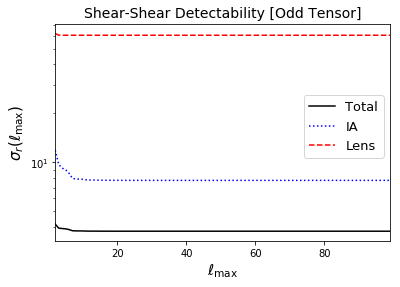

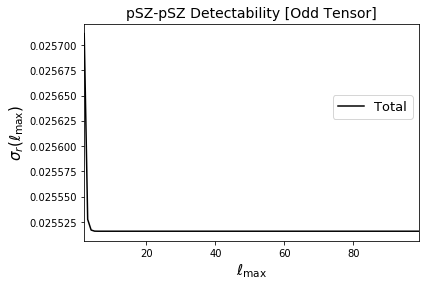

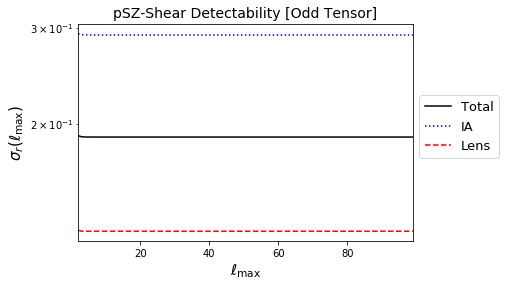

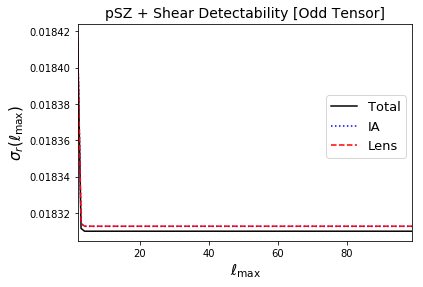

In [272]:
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_gg_tot))),label='Total',c='k',ls='-')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_gg_IA))),label='IA',ls=':',c='b')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_gg_lens))),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('Shear-Shear Detectability [Odd Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
plt.yscale('log')

plt.figure()
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_qq_tot))),label='Total',c='k',ls='-')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-pSZ Detectability [Odd Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
#plt.yscale('log')

plt.figure()
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_cross_tot))),label='Total',c='k',ls='-')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_cross_IA))),label='IA',ls=':',c='b')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_cross_lens))),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ-Shear Detectability [Odd Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
plt.yscale('log')

plt.figure()
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_joint_tot))),label='Total',c='k',ls='-')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_joint_IA))),label='IA',ls=':',c='b')
plt.plot(l_arr,1./(np.sqrt(np.cumsum(dl*ofish_joint_lens))),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('pSZ + Shear Detectability [Odd Tensor]',fontsize=14)
plt.ylabel(r'$\sigma_r(\ell_{\rm max})$',fontsize=15);
#plt.yscale('log')

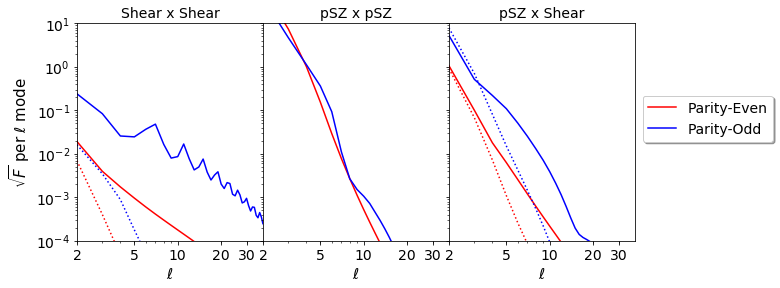

In [286]:
fig,ax = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(l_arr,np.sqrt(dl*fish_gg_tot),label='Parity-Even',c='r',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*ofish_gg_tot),label='Parity-Odd',c='b',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_gg_lens),c='r',ls=':')
ax[0].plot(l_arr,np.sqrt(dl*ofish_gg_lens),c='b',ls=':')
ax[0].set_title('Shear x Shear',fontsize=14)
ax[0].set_ylabel(r'$\sqrt{F}$ per $\ell$ mode',fontsize=15);
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim([1e-4,10])
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(l_arr,np.sqrt(dl*fish_qq_tot),label='Parity-Even',c='r',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*ofish_qq_tot),label='Parity-Odd',c='b',ls='-')
ax[1].set_title('pSZ x pSZ',fontsize=14)

ax[2].plot(l_arr,np.sqrt(dl*fish_cross_tot),label='Parity-Even',c='r',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*ofish_cross_tot),label='Parity-Odd',c='b',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_cross_lens),c='r',ls=':')
ax[2].plot(l_arr,np.sqrt(dl*ofish_cross_lens),c='b',ls=':')
ax[2].set_title('pSZ x Shear',fontsize=14)

ax[0].set_xlim([2,39])
for j in range(3):
    ax[j].set_xticklabels([2,5,10,20,30])
    ax[j].set_xticks([2,5,10,20,30])
    ax[j].set_xlabel(r'$\ell$',fontsize=15)
    ax[j].tick_params(axis='x', labelsize=14)

ax[0].legend(fontsize=14,fancybox=True,shadow=True,ncol=1,bbox_to_anchor=(3.78,0.7));
fig.savefig('SN_tensor.pdf',bbox_inches='tight')